<a href="https://colab.research.google.com/github/Vania1021/AiMl-Project-Sem-5/blob/main/AiMl_project_main1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Preprocess the data in "/content/IMDB_parental_guide.csv" by performing initial cleaning, handling missing values, encoding severity and certification data, engineering features for user vote distributions, validating data, removing outliers, normalizing and correcting for imbalance, and performing contextual augmentation. Finally, conduct exploratory data analysis with visualizations and save the processed data.

## Load data

### Subtask:
Load the dataset from "/content/IMDB_parental_guide.csv" into a pandas DataFrame.


**Reasoning**:
The first step is to load the data into a pandas DataFrame and display the head to confirm it loaded correctly.



In [ ]:
# ====================================================
# FULL PREPROCESSING PIPELINE — BALANCED 5-CLASS MPAA
# ====================================================

import re
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

INPUT_PATH = "/content/IMDB_parental_guide.csv"
OUTPUT_FULL = "/content/preprocessed_full_with_ids.csv"
OUTPUT_SMOTE_X = "/content/X_mpaa_5class_balanced.csv"
OUTPUT_SMOTE_Y = "/content/y_mpaa_5class_balanced.csv"

# =====================================================
# 1. LOAD DATA
# =====================================================
df = pd.read_csv(INPUT_PATH)
print("Loaded rows:", len(df))

# =====================================================
# 2. KEEP RELEVANT COLUMNS
# =====================================================
cols_to_keep = [
    'tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
    'startYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
    'sex', 'violence', 'profanity', 'drugs', 'intense',
    'sex_code', 'violence_code', 'profanity_code', 'drug_code', 'intense_code',
    'mpaa', 'certificate'
]

cols_to_keep = [c for c in cols_to_keep if c in df.columns]
df = df[cols_to_keep].copy()

# String cleanup
text_cols = ['sex','violence','profanity','drugs','intense','mpaa','certificate','titleType']
for c in text_cols:
    if c in df.columns:
        df[c] = df[c].astype(str).replace({'nan': np.nan}).str.strip()

# Numeric cleanup
for col in ['numVotes','startYear','runtimeMinutes','averageRating','isAdult']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df['isAdult'] = df['isAdult'].fillna(0).astype(int)

# =====================================================
# 3. HANDLE SEVERITY MISSING VALUES
# =====================================================
severity_text_cols = ['sex','violence','profanity','drugs','intense']
for c in severity_text_cols:
    if c in df.columns:
        df[c] = df[c].fillna("None")

severity_code_cols = ['sex_code','violence_code','profanity_code','drug_code','intense_code']
for c in severity_code_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).astype(int)

# =====================================================
# 4. SMART MPAA CONSOLIDATION INTO 5 CLASSES
# =====================================================
def smart_mpaa_map(raw):
    if pd.isna(raw):
        return "PG13"
    s = str(raw).upper().strip()
    s_clean = re.sub(r'[^A-Z0-9\-\s]', '', s)

    if re.fullmatch(r'G', s_clean) or "RATED G" in s_clean:
        return "G"
    if "PG-13" in s_clean or "PG13" in s_clean:
        return "PG13"
    if re.fullmatch(r'PG', s_clean):
        return "PG"
    if re.fullmatch(r'R', s_clean) or "RATED R" in s_clean:
        return "R"
    if "NC17" in s_clean or "NC-17" in s_clean or "ADULT" in s_clean or "X" in s_clean:
        return "NC17"

    # TV Ratings
    if "TV-MA" in s_clean: return "R"
    if "TV-14" in s_clean: return "PG13"
    if "TV-PG" in s_clean: return "PG"

    # Unrated → middle
    if "UNRATED" in s_clean or "NOT RATED" in s_clean or s_clean == "NR":
        return "PG13"

    return "PG13"

df['mpaa_consolidated'] = df['mpaa'].apply(smart_mpaa_map)
df['mpaa_consolidated'] = df['mpaa_consolidated'].replace({'G':'G'})

print("\nMPAA class distribution BEFORE balancing:")
print(df['mpaa_consolidated'].value_counts())

# =====================================================
# 5. SEVERITY TEXT → NUMERIC
# =====================================================
severity_map = {'None':0,'Mild':1,'Moderate':2,'Severe':3}

for c in severity_text_cols:
    df[c+"_encoded"] = df[c].apply(
        lambda x: severity_map.get(x.title(),
            (3 if "severe" in x.lower() else
             2 if "moderate" in x.lower() else
             1 if "mild" in x.lower() else 0))
    )

for text_col, code_col in zip(severity_text_cols, severity_code_cols):
    if code_col in df.columns:
        if df[code_col].nunique() <= 1:
            df[code_col] = df[text_col+"_encoded"]
    else:
        df[code_col] = df[text_col+"_encoded"]

# =====================================================
# 6. FEATURE ENGINEERING
# =====================================================
df['numVotes'] = df['numVotes'].fillna(df['numVotes'].median())
df['numVotes_log'] = df['numVotes'].apply(lambda x: 0 if x<=0 else np.log10(x))
df['numVotes_bin'] = pd.qcut(df['numVotes'].rank(method='first'), 5, labels=False)

df['startYear'] = df['startYear'].fillna(df['startYear'].median()).astype(int)
df['Decade'] = (df['startYear'] // 10) * 10

def extract_country(cert):
    if cert is None or cert == "Not Available":
        return "Unknown"
    parts = str(cert).split("|")
    first = parts[0]
    if ":" in first:
        return first.split(":")[0]
    return first.split()[0]

df['Country'] = df['certificate'].fillna("Not Available").apply(extract_country)

# =====================================================
# 7. NORMALIZATION
# =====================================================
scaler_cols = [
    'sex_code','violence_code','profanity_code','drug_code','intense_code',
    'numVotes_log'
]
scaler_cols = [c for c in scaler_cols if c in df.columns]

scaler = MinMaxScaler()
df[scaler_cols] = scaler.fit_transform(df[scaler_cols])

# =====================================================
# 8. LABEL ENCODING
# =====================================================
label_encoder = LabelEncoder()
df['mpaa_encoded'] = label_encoder.fit_transform(df['mpaa_consolidated'])
df['country_encoded'] = LabelEncoder().fit_transform(df['Country'])
df['titleType_encoded'] = LabelEncoder().fit_transform(df['titleType'])

# =====================================================
# 9. SAVE NON-SMOTE FULL DATASET WITH IDS
# =====================================================
full_cols = [
    'tconst','primaryTitle','titleType','startYear','Decade',
    'numVotes','numVotes_log','numVotes_bin',
    'sex_code','violence_code','profanity_code','drug_code','intense_code',
    'mpaa_consolidated','mpaa_encoded','country_encoded','titleType_encoded'
]
df[full_cols].to_csv(OUTPUT_FULL, index=False)
print(f"\nSaved NON-SMOTE dataset → {OUTPUT_FULL}")

# =====================================================
# 10. FORCE ALL 5 CLASSES TO EXIST (SEED TRICK)
# =====================================================
required_classes = ["G","PG","PG13","R","NC17"]

for cls in required_classes:
    if cls not in df['mpaa_consolidated'].unique():
        print(f"Adding synthetic seed for missing class: {cls}")
        seed = df.iloc[0].copy()
        seed['mpaa_consolidated'] = cls
        # Add two copies of the seed to ensure at least 2 samples for SMOTE's k_neighbors=1
        df = pd.concat([df, pd.DataFrame([seed]), pd.DataFrame([seed])], ignore_index=True)

df['mpaa_encoded'] = LabelEncoder().fit_transform(df['mpaa_consolidated'])

# =====================================================
# 11. SELECT SMOTE FEATURES (OPTION A)
# =====================================================
smote_features = [
    'sex_code','violence_code','profanity_code','drug_code','intense_code',
    'numVotes_log','numVotes_bin',
    'averageRating','runtimeMinutes',
    'country_encoded','titleType_encoded','Decade'
]
smote_features = [c for c in smote_features if c in df.columns]

X = df[smote_features].copy()
y = df['mpaa_encoded'].copy()

# =====================================================
# 12. APPLY SMOTE FOR MPAA BALANCING (5 CLASSES)
# =====================================================
print("\nApplying SMOTE to MPAA (5-class)...")

# Changed k_neighbors from 3 to 1 to accommodate classes with very few samples
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nAFTER SMOTE (balanced MPAA distribution):")
print(pd.Series(y_resampled).value_counts())

# Save balanced datasets
pd.DataFrame(X_resampled, columns=X.columns).to_csv(OUTPUT_SMOTE_X, index=False)
pd.Series(y_resampled, name='mpaa_encoded').to_csv(OUTPUT_SMOTE_Y, index=False)

print(f"\nBalanced X saved → {OUTPUT_SMOTE_X}")
print(f"Balanced y saved → {OUTPUT_SMOTE_Y}")

print("\n🎉 FULL 5-CLASS MPAA PREPROCESSING COMPLETE!")

Loaded rows: 53228

MPAA class distribution BEFORE balancing:
mpaa_consolidated
PG13    45154
R        7990
NC17       84
Name: count, dtype: int64

Saved NON-SMOTE dataset → /content/preprocessed_full_with_ids.csv
Adding synthetic seed for missing class: G
Adding synthetic seed for missing class: PG

Applying SMOTE to MPAA (5-class)...

AFTER SMOTE (balanced MPAA distribution):
mpaa_encoded
4    45154
3    45154
1    45154
0    45154
2    45154
Name: count, dtype: int64

Balanced X saved → /content/X_mpaa_5class_balanced.csv
Balanced y saved → /content/y_mpaa_5class_balanced.csv

🎉 FULL 5-CLASS MPAA PREPROCESSING COMPLETE!


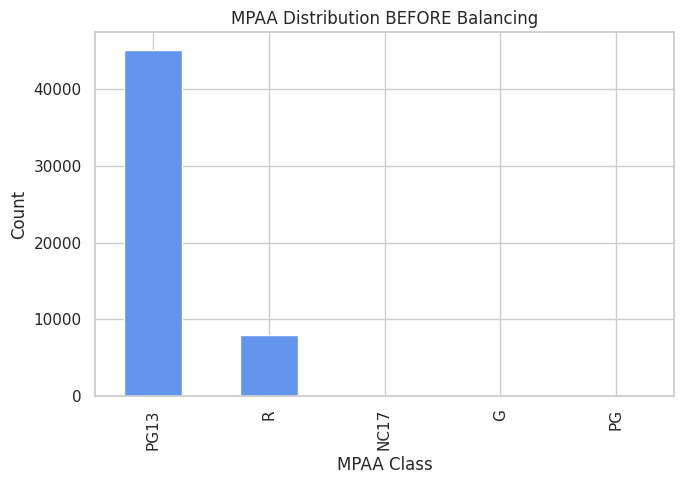

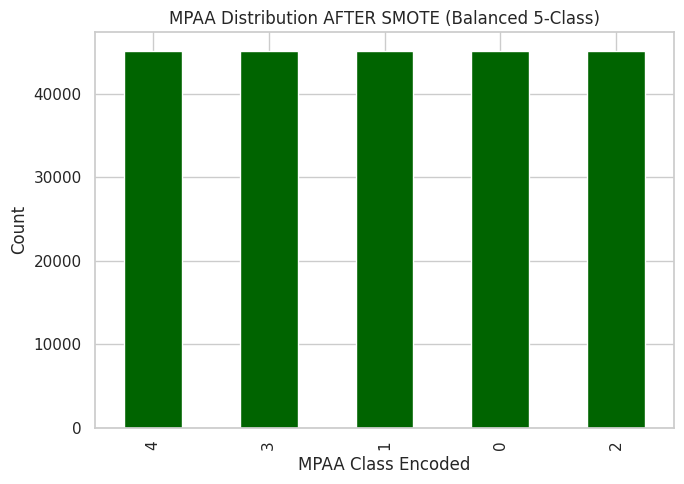

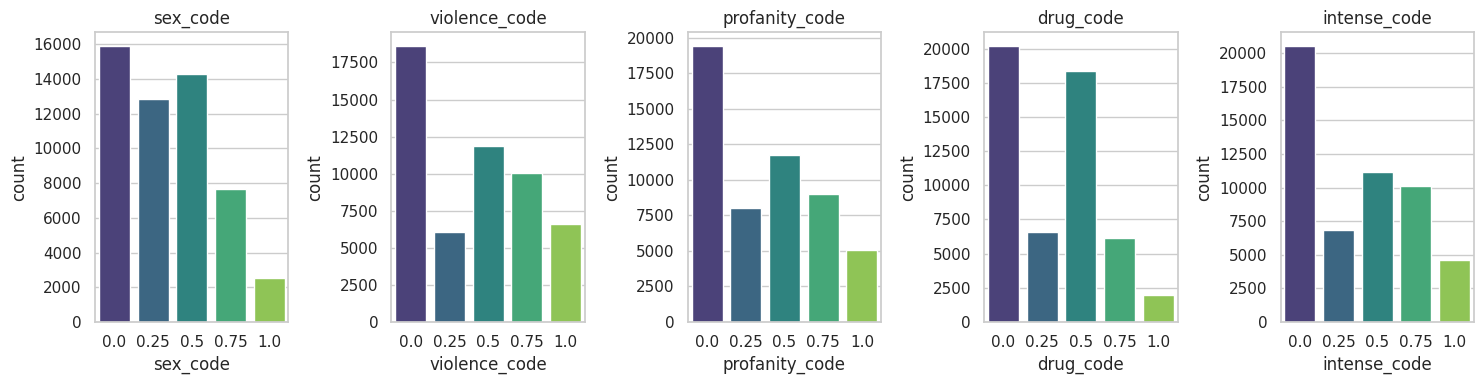

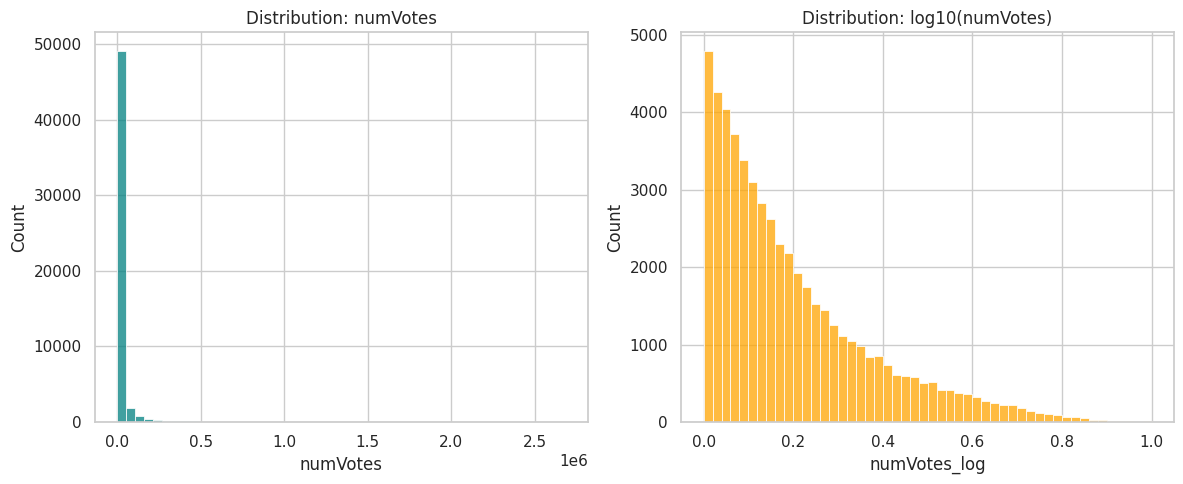

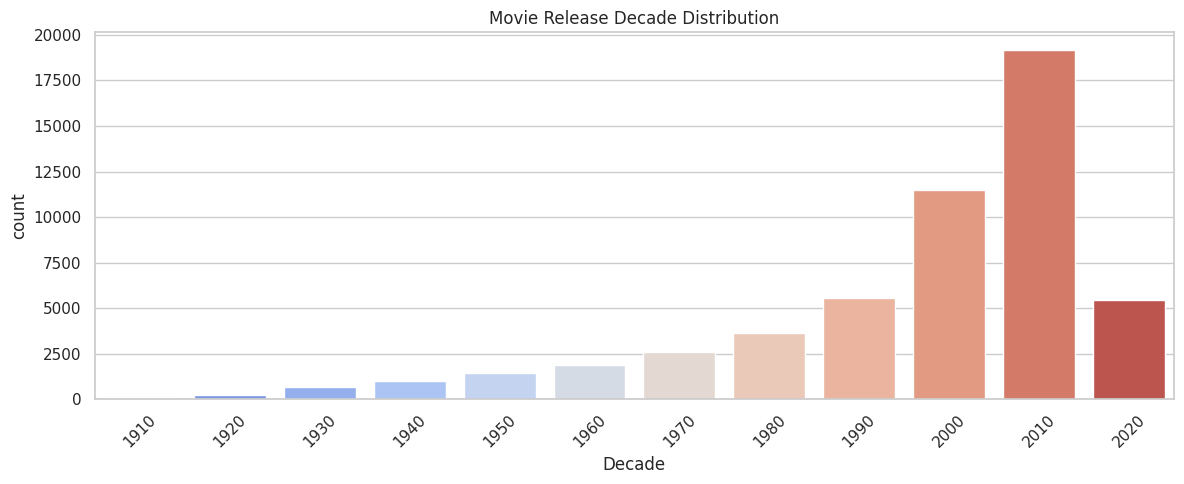

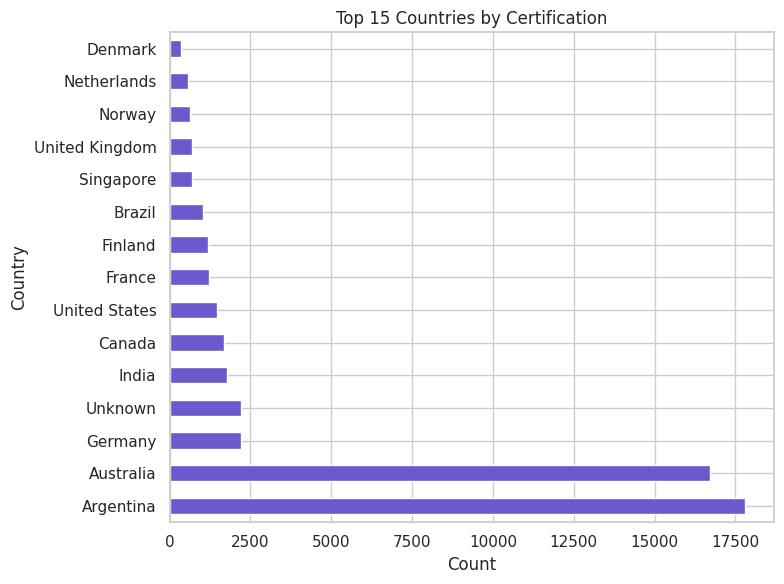

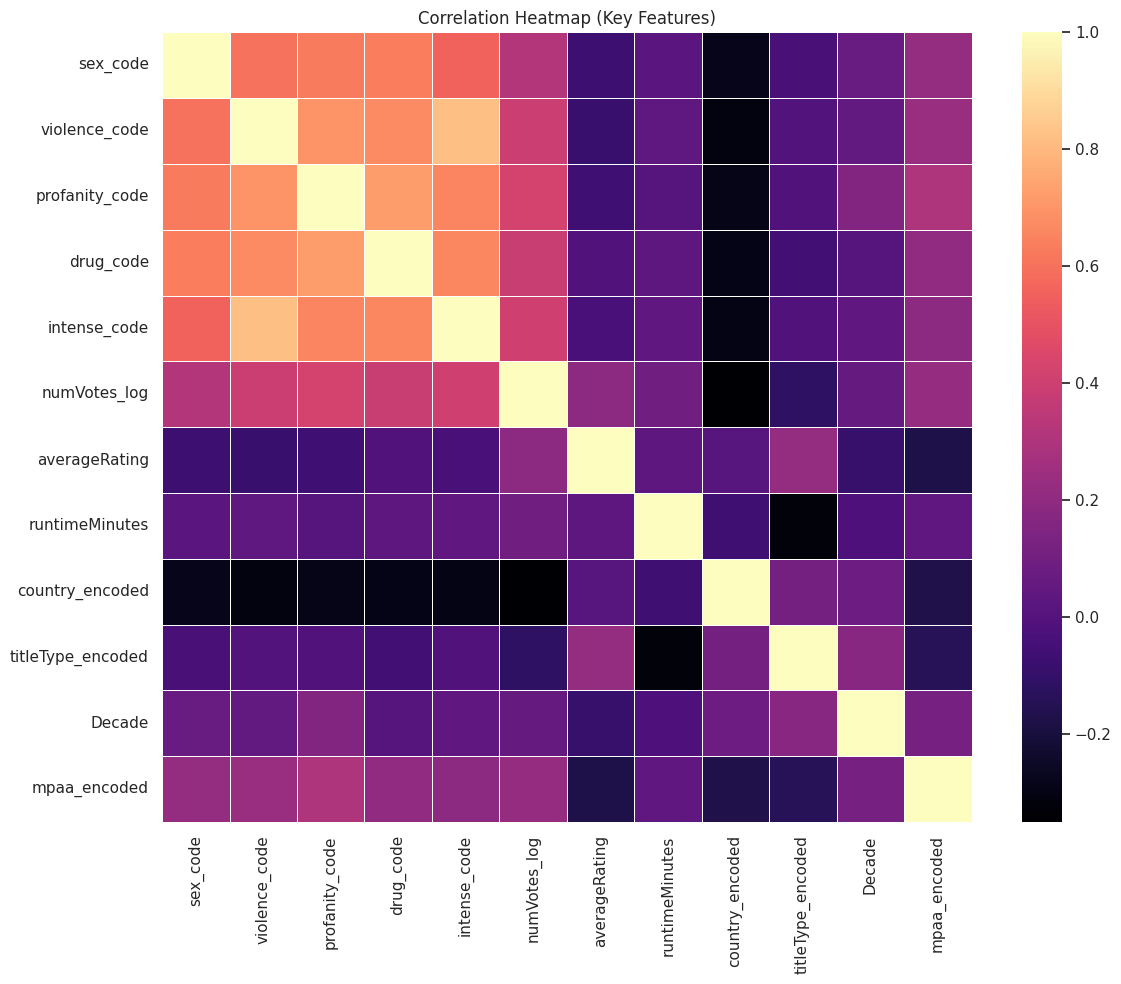

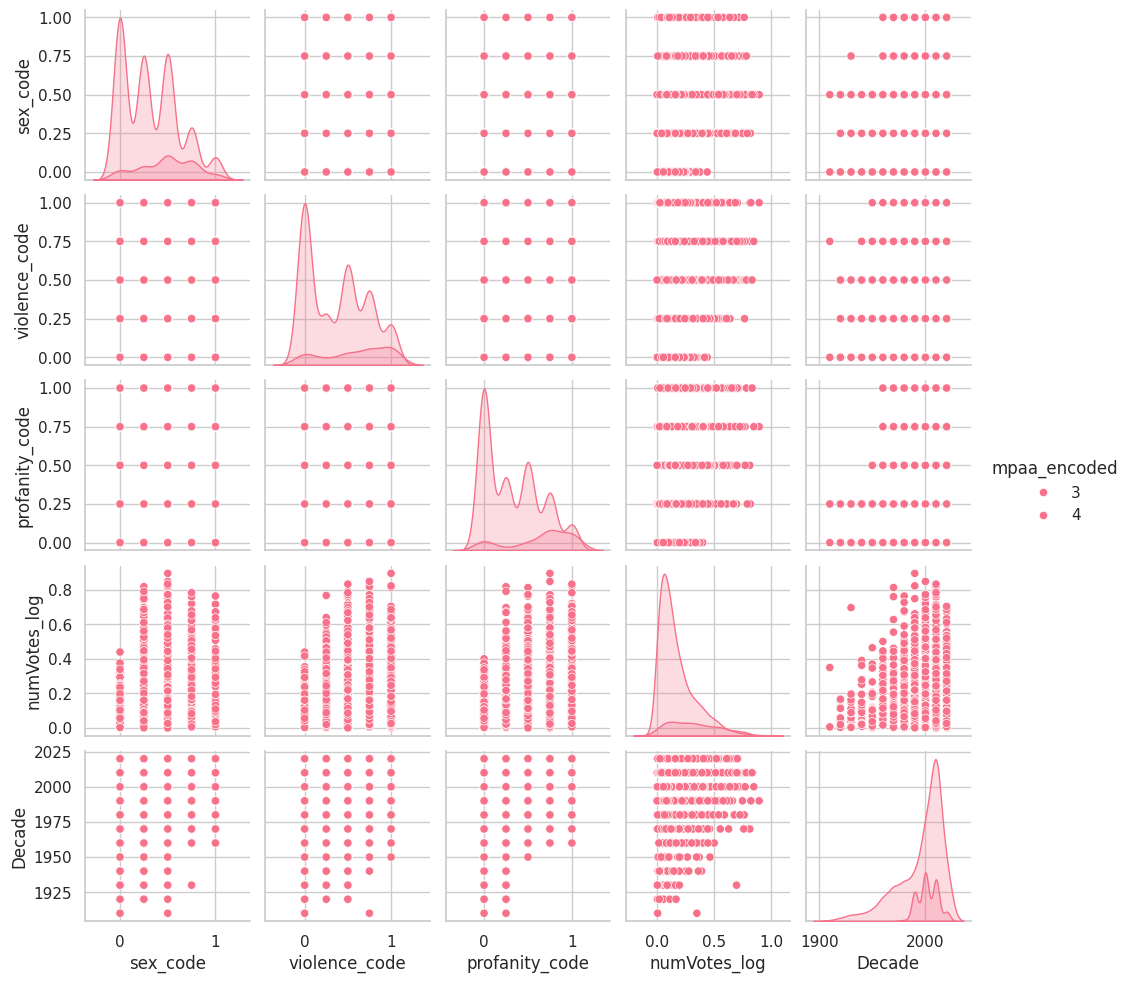


📊 All EDA plots generated successfully!


In [2]:
# =====================================================
# 📊 EDA PLOTS FOR PREPROCESSED DATA
# =====================================================
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# -----------------------------------------------------
# 1. MPAA Distribution BEFORE balancing
# -----------------------------------------------------
plt.figure(figsize=(7,5))
df['mpaa_consolidated'].value_counts().plot(kind='bar', color='cornflowerblue')
plt.title("MPAA Distribution BEFORE Balancing")
plt.xlabel("MPAA Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# 2. MPAA Distribution AFTER SMOTE
# -----------------------------------------------------
plt.figure(figsize=(7,5))
pd.Series(y_resampled).value_counts().plot(kind='bar', color='darkgreen')
plt.title("MPAA Distribution AFTER SMOTE (Balanced 5-Class)")
plt.xlabel("MPAA Class Encoded")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# 3. Severity Code Distributions
# -----------------------------------------------------
severity_cols = ['sex_code','violence_code','profanity_code','drug_code','intense_code']
plt.figure(figsize=(15,4))
for i, col in enumerate(severity_cols):
    plt.subplot(1,5,i+1)
    sns.countplot(x=df[col], palette="viridis")
    plt.title(col)
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# 4. NumVotes (raw) and NumVotes_log distribution
# -----------------------------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df['numVotes'], bins=50, color='teal')
plt.title("Distribution: numVotes")

plt.subplot(1,2,2)
sns.histplot(df['numVotes_log'], bins=50, color='orange')
plt.title("Distribution: log10(numVotes)")

plt.tight_layout()
plt.show()


# -----------------------------------------------------
# 5. Decade Distribution
# -----------------------------------------------------
plt.figure(figsize=(12,5))
sns.countplot(x=df['Decade'], palette="coolwarm")
plt.title("Movie Release Decade Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# 6. Country Distribution (Top 15)
# -----------------------------------------------------
plt.figure(figsize=(8,6))
df['Country'].value_counts().head(15).plot(kind='barh', color='slateblue')
plt.title("Top 15 Countries by Certification")
plt.xlabel("Count")
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# 7. Correlation Heatmap (after encoding)
# -----------------------------------------------------
corr_cols = [
    'sex_code','violence_code','profanity_code','drug_code','intense_code',
    'numVotes_log','averageRating','runtimeMinutes',
    'country_encoded','titleType_encoded','Decade',
    'mpaa_encoded'
]

corr = df[corr_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=False, cmap="magma", linewidths=.5)
plt.title("Correlation Heatmap (Key Features)")
plt.tight_layout()
plt.show()


# -----------------------------------------------------
# 8. Pairplot for 5 key numeric predictors (optional)
# ⚠️ Warning: Large datasets = slow. Use sample.
# -----------------------------------------------------
sample_df = df.sample(1500, random_state=42)

sns.pairplot(
    sample_df[['sex_code','violence_code','profanity_code','numVotes_log','Decade','mpaa_encoded']],
    hue='mpaa_encoded',
    palette='husl',
    height=2
)
plt.show()

print("\n📊 All EDA plots generated successfully!")


In [3]:
pip install xgboost lightgbm catboost optuna shap joblib


Loaded balanced dataset: (225770, 12)

TRAINING: Logistic Regression

Accuracy: 0.5880320680338398
Macro F1: 0.5188482427868414

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      9031
           1       0.62      0.77      0.69      9030
           2       0.50      1.00      0.67      9031
           3       0.73      0.69      0.71      9031
           4       0.59      0.48      0.53      9031

    accuracy                           0.59     45154
   macro avg       0.49      0.59      0.52     45154
weighted avg       0.49      0.59      0.52     45154



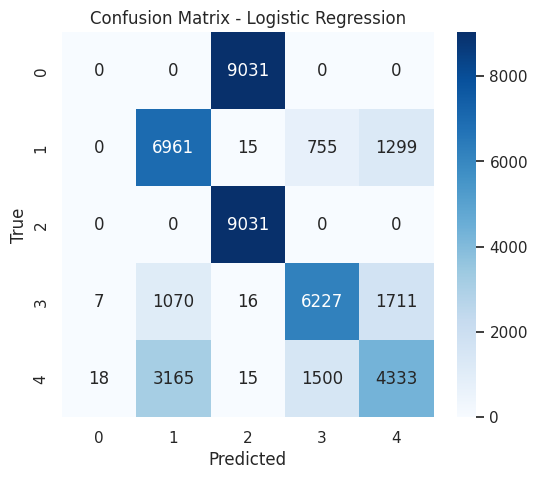


TRAINING: Decision Tree

Accuracy: 0.7617265358550738
Macro F1: 0.69506105728528

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      9031
           1       1.00      1.00      1.00      9030
           2       0.00      0.00      0.00      9031
           3       0.91      0.90      0.91      9031
           4       0.90      0.91      0.91      9031

    accuracy                           0.76     45154
   macro avg       0.66      0.76      0.70     45154
weighted avg       0.66      0.76      0.70     45154



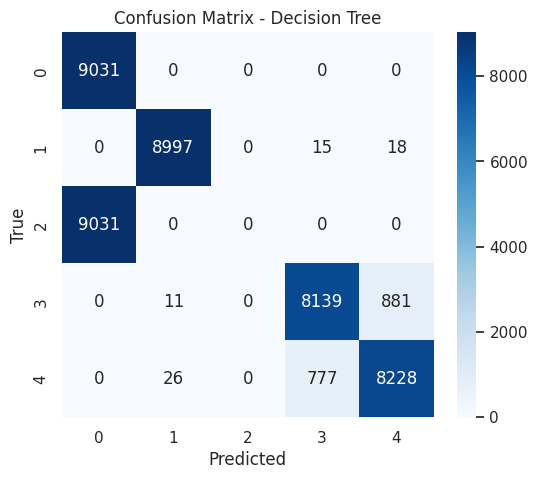


TRAINING: KNN

Accuracy: 0.7518935199539354
Macro F1: 0.6846631637277577

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      9031
           1       0.99      1.00      0.99      9030
           2       0.00      0.00      0.00      9031
           3       0.97      0.79      0.87      9031
           4       0.83      0.97      0.89      9031

    accuracy                           0.75     45154
   macro avg       0.66      0.75      0.68     45154
weighted avg       0.66      0.75      0.68     45154



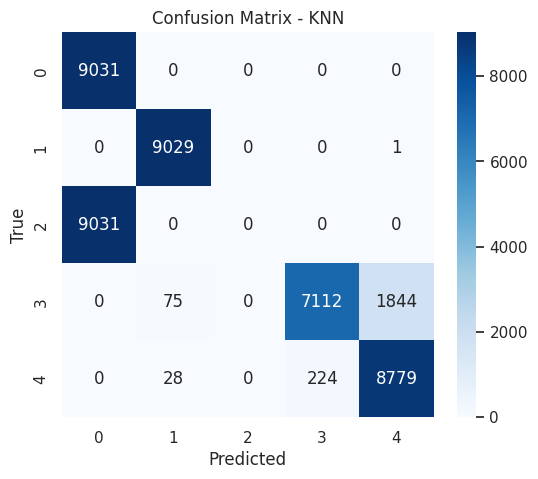


TRAINING: Random Forest

Accuracy: 0.7759223989015369
Macro F1: 0.709275524218764

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      9031
           1       1.00      1.00      1.00      9030
           2       0.00      0.00      0.00      9031
           3       0.93      0.95      0.94      9031
           4       0.95      0.93      0.94      9031

    accuracy                           0.78     45154
   macro avg       0.68      0.78      0.71     45154
weighted avg       0.68      0.78      0.71     45154



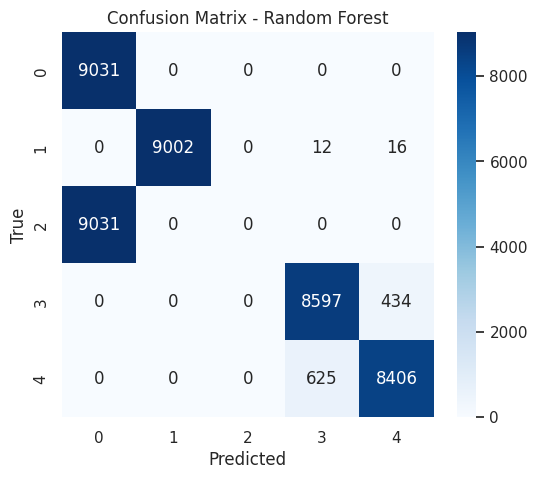


TRAINING: Gradient Boosting

Accuracy: 0.7491695087921336
Macro F1: 0.6820009988228302

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      9031
           1       0.94      0.99      0.96      9030
           2       0.00      0.00      0.00      9031
           3       0.91      0.90      0.91      9031
           4       0.90      0.85      0.87      9031

    accuracy                           0.75     45154
   macro avg       0.65      0.75      0.68     45154
weighted avg       0.65      0.75      0.68     45154



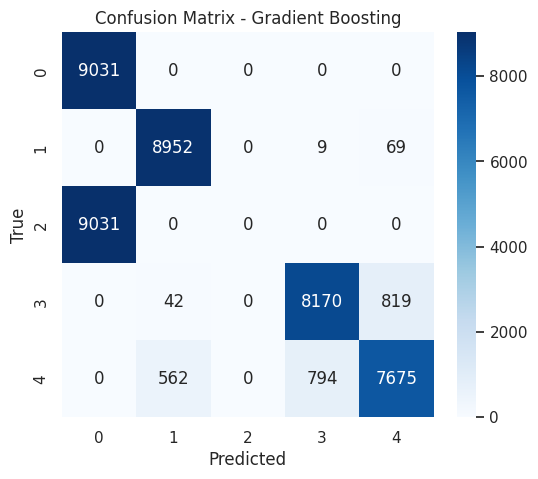


TRAINING: XGBoost

Accuracy: 0.7719803339681978
Macro F1: 0.705326870179397

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      9031
           1       1.00      1.00      1.00      9030
           2       0.00      0.00      0.00      9031
           3       0.92      0.94      0.93      9031
           4       0.94      0.92      0.93      9031

    accuracy                           0.77     45154
   macro avg       0.67      0.77      0.71     45154
weighted avg       0.67      0.77      0.71     45154



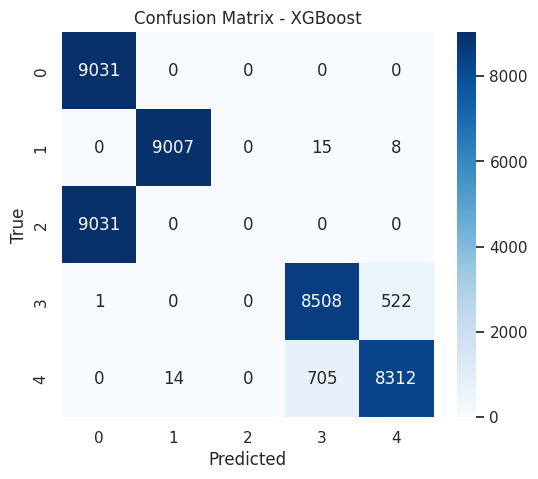


TRAINING: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2175
[LightGBM] [Info] Number of data points in the train set: 180616, number of used features: 12
[LightGBM] [Info] Start training from score -1.609443
[LightGBM] [Info] Start training from score -1.609416
[LightGBM] [Info] Start training from score -1.609443
[LightGBM] [Info] Start training from score -1.609443
[LightGBM] [Info] Start training from score -1.609443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Accuracy: 0.7710501838153874
Macro F1: 0.70437931703909

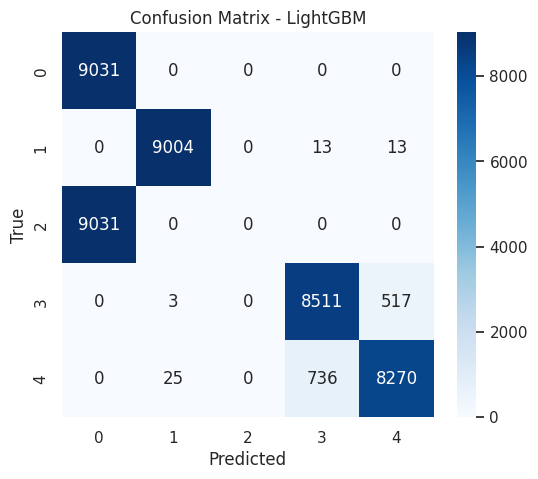


TRAINING: CatBoost

Accuracy: 0.7723568233157638
Macro F1: 0.7056773744752045

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67      9031
           1       1.00      1.00      1.00      9030
           2       0.00      0.00      0.00      9031
           3       0.92      0.95      0.93      9031
           4       0.94      0.92      0.93      9031

    accuracy                           0.77     45154
   macro avg       0.67      0.77      0.71     45154
weighted avg       0.67      0.77      0.71     45154



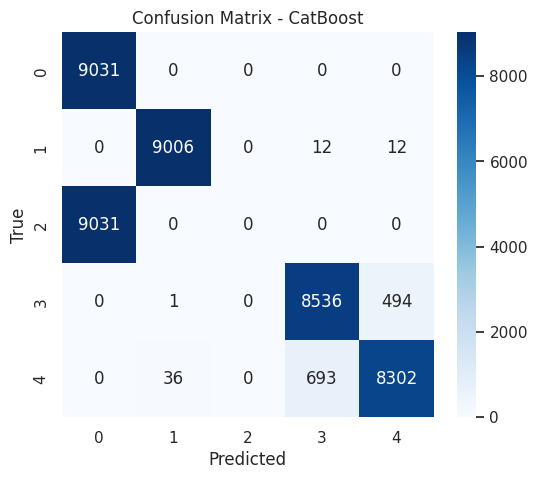


TRAINING: Bagging Classifier

Accuracy: 0.7727997519599592
Macro F1: 0.7061438618883503

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      9031
           1       1.00      1.00      1.00      9030
           2       0.50      1.00      0.67      9031
           3       0.92      0.95      0.93      9031
           4       0.94      0.92      0.93      9031

    accuracy                           0.77     45154
   macro avg       0.67      0.77      0.71     45154
weighted avg       0.67      0.77      0.71     45154



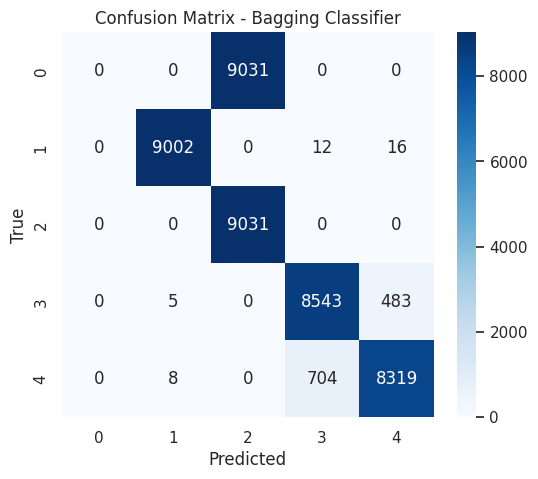


TRAINING: Voting Classifier

Accuracy: 0.7724675554768127
Macro F1: 0.7058263604472947

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      9031
           1       1.00      1.00      1.00      9030
           2       0.50      1.00      0.67      9031
           3       0.93      0.93      0.93      9031
           4       0.93      0.93      0.93      9031

    accuracy                           0.77     45154
   macro avg       0.67      0.77      0.71     45154
weighted avg       0.67      0.77      0.71     45154



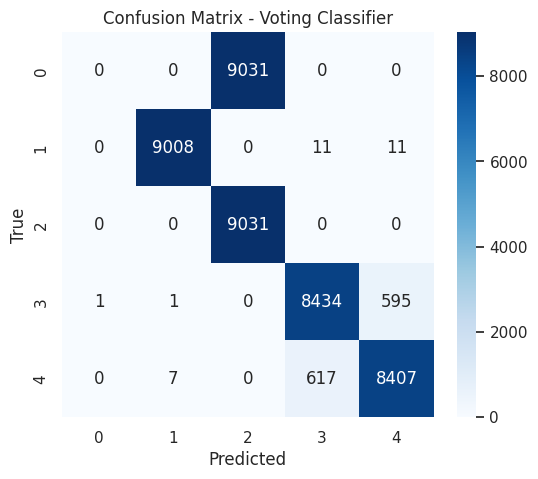


TRAINING: AdaBoost

Accuracy: 0.532200912433007
Macro F1: 0.42565779590604313

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      9031
           1       0.48      0.94      0.63      9030
           2       0.50      1.00      0.67      9031
           3       0.74      0.64      0.69      9031
           4       0.49      0.08      0.14      9031

    accuracy                           0.53     45154
   macro avg       0.44      0.53      0.43     45154
weighted avg       0.44      0.53      0.43     45154



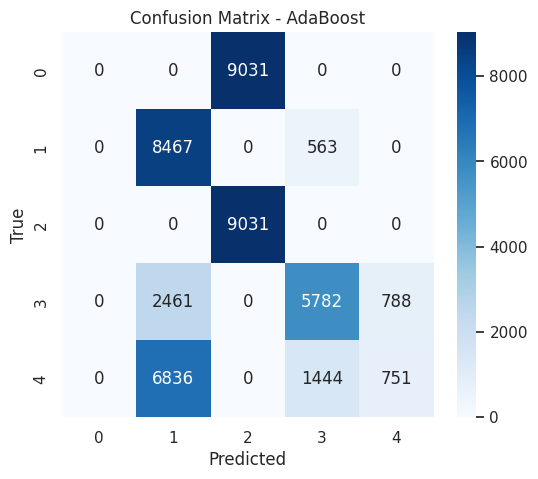


TRAINING: MLP Neural Network

Accuracy: 0.20009301501528104
Macro F1: 0.06684990798280134

Classification Report:
               precision    recall  f1-score   support

           0       0.20      1.00      0.33      9031
           1       0.00      0.00      0.00      9030
           2       0.00      0.00      0.00      9031
           3       1.00      0.00      0.00      9031
           4       0.00      0.00      0.00      9031

    accuracy                           0.20     45154
   macro avg       0.24      0.20      0.07     45154
weighted avg       0.24      0.20      0.07     45154



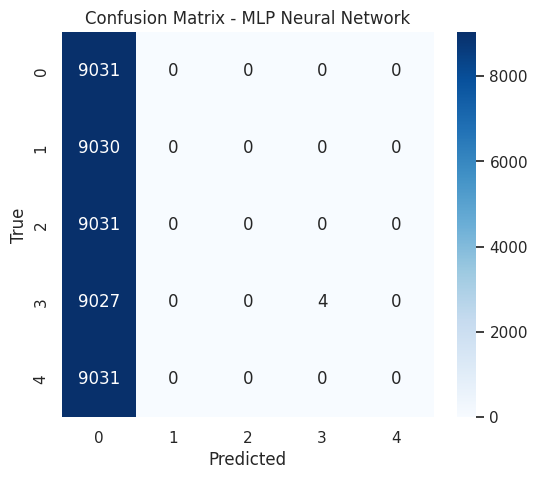

accuracy  macro_f1
Logistic Regression  0.588032  0.518848
Decision Tree        0.761727  0.695061
KNN                  0.751894  0.684663
Random Forest        0.775922  0.709276
Gradient Boosting    0.749170  0.682001
XGBoost              0.771980  0.705327
LightGBM             0.771050  0.704379
CatBoost             0.772357  0.705677
Bagging Classifier   0.772800  0.706144
Voting Classifier    0.772468  0.705826
AdaBoost             0.532201  0.425658
MLP Neural Network   0.200093  0.066850

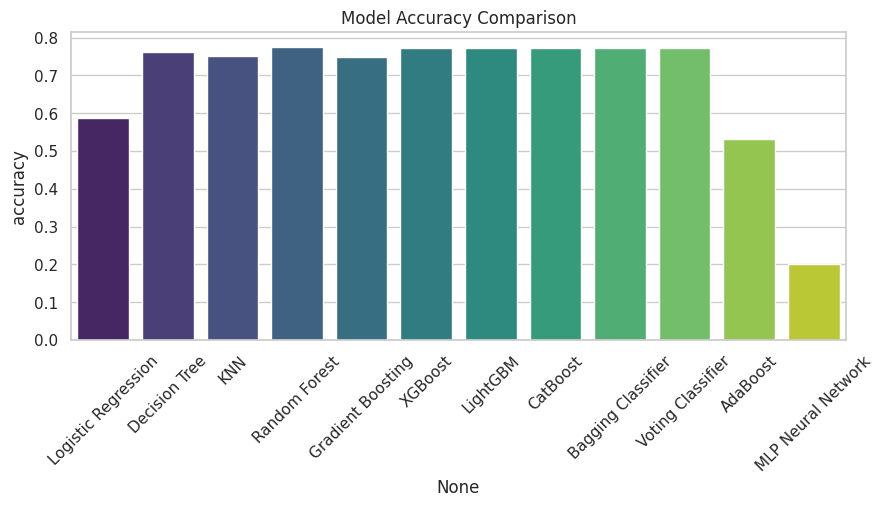

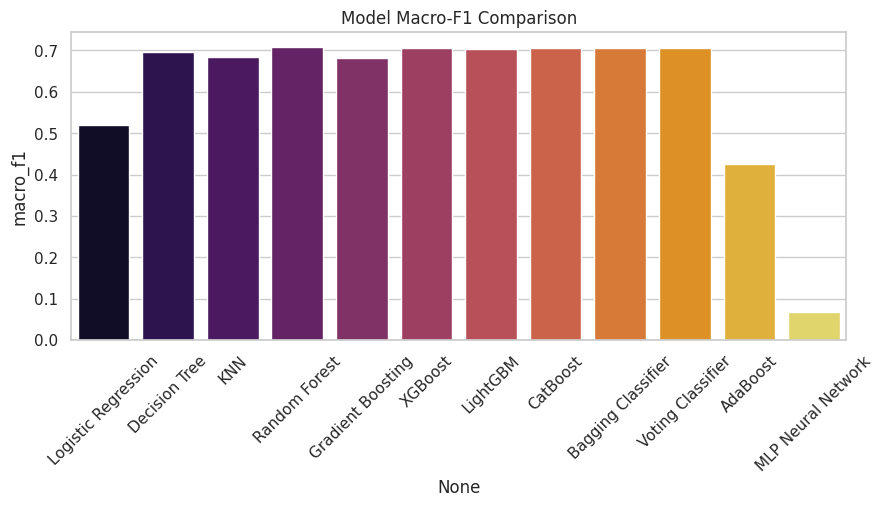


🎉 Training complete for ALL MODELS!


In [4]:
# =========================================================
# TRAINING PIPELINE FOR 5-CLASS MPAA CLASSIFICATION
# =========================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Base ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Ensembles
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
    AdaBoostClassifier
)

# Boosting libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Neural Network
from sklearn.neural_network import MLPClassifier

# Stacking
from sklearn.ensemble import StackingClassifier


# =========================================================
# 1. LOAD THE BALANCED DATASET
# =========================================================

X = pd.read_csv("/content/X_mpaa_5class_balanced.csv")
y = pd.read_csv("/content/y_mpaa_5class_balanced.csv")['mpaa_encoded']

print("Loaded balanced dataset:", X.shape)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# =========================================================
# 2. MODEL DEFINITIONS
# =========================================================

models = {
    "Logistic Regression": LogisticRegression(max_iter=3000, multi_class='multinomial'),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(
        objective='multi:softprob', num_class=5, eval_metric='mlogloss', random_state=42
    ),
    "LightGBM": LGBMClassifier(objective='multiclass', num_class=5, random_state=42),
    "CatBoost": CatBoostClassifier(
        verbose=0, objective='MultiClass', random_state=42
    ),
    "Bagging Classifier": BaggingClassifier(
        n_estimators=20, random_state=42
    ),

    # Voting Classifier
    "Voting Classifier": VotingClassifier(
        estimators=[
            ('lr', LogisticRegression(max_iter=3000, multi_class='multinomial')),
            ('rf', RandomForestClassifier(n_estimators=200)),
            ('xgb', XGBClassifier(
                objective='multi:softprob', num_class=5, eval_metric='mlogloss'
            ))
        ],
        voting='soft'
    ),

    # Stacking Classifier
    # "Stacking Classifier": StackingClassifier(
    #     estimators=[
    #         ('rf', RandomForestClassifier()),
    #         ('svm', SVC(probability=True)),
    #         ('gb', GradientBoostingClassifier())
    #     ],
    #     final_estimator=LogisticRegression(max_iter=2000),
    #     cv=5
    # ),

    # AdaBoost
    "AdaBoost": AdaBoostClassifier(n_estimators=150, learning_rate=0.7, random_state=42),

    # Multi-Layer Perceptron
    "MLP Neural Network": MLPClassifier(
        hidden_layer_sizes=(256, 128, 64),
        activation='relu',
        solver='adam',
        max_iter=500,
        random_state=42
    )
}

# =========================================================
# 3. TRAIN & EVALUATE MODELS
# =========================================================

results = {}

for name, model in models.items():
    print(f"\n========================================")
    print(f"TRAINING: {name}")
    print(f"========================================")

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    acc = accuracy_score(y_test, preds)
    macro_f1 = f1_score(y_test, preds, average='macro')

    print("\nAccuracy:", acc)
    print("Macro F1:", macro_f1)
    print("\nClassification Report:\n", classification_report(y_test, preds))

    # Save results
    results[name] = {"accuracy": acc, "macro_f1": macro_f1}

    # Confusion Matrix Plot
    plt.figure(figsize=(6,5))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# =========================================================
# 4. SUMMARY RESULTS TABLE
# =========================================================

results_df = pd.DataFrame(results).T
display(results_df)

plt.figure(figsize=(10,4))
sns.barplot(x=results_df.index, y=results_df['accuracy'], palette='viridis')
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x=results_df.index, y=results_df['macro_f1'], palette='inferno')
plt.xticks(rotation=45)
plt.title("Model Macro-F1 Comparison")
plt.show()

print("\n🎉 Training complete for ALL MODELS!")



===== MULTICLASS ROC-AUC CURVES =====


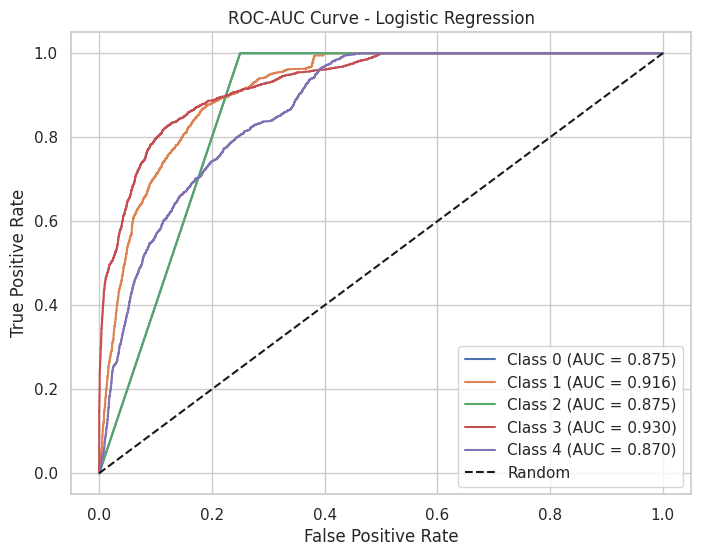

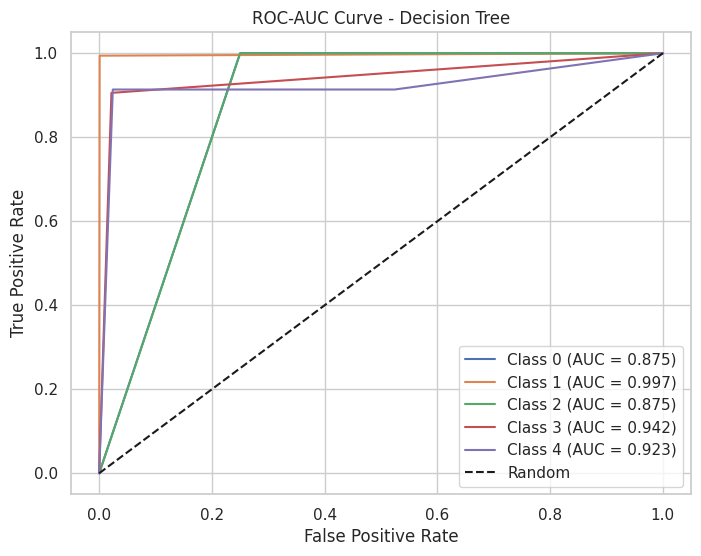

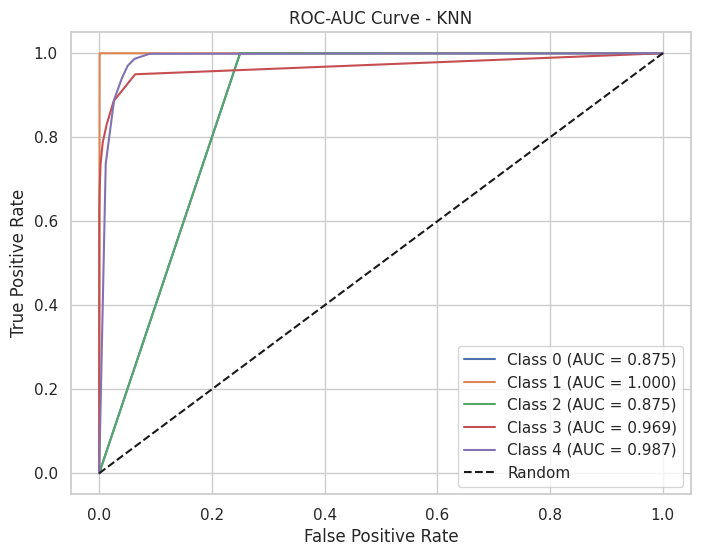

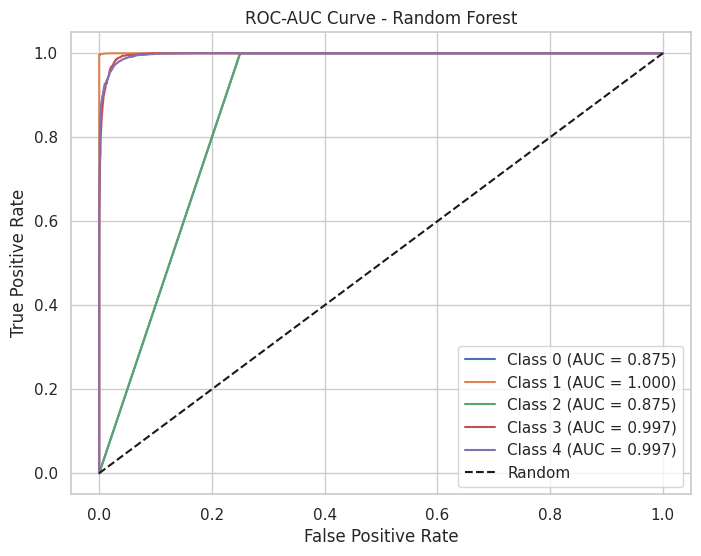

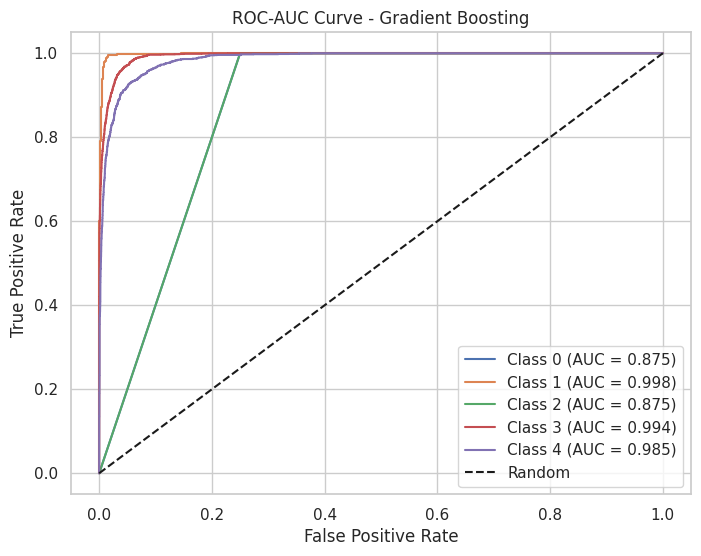

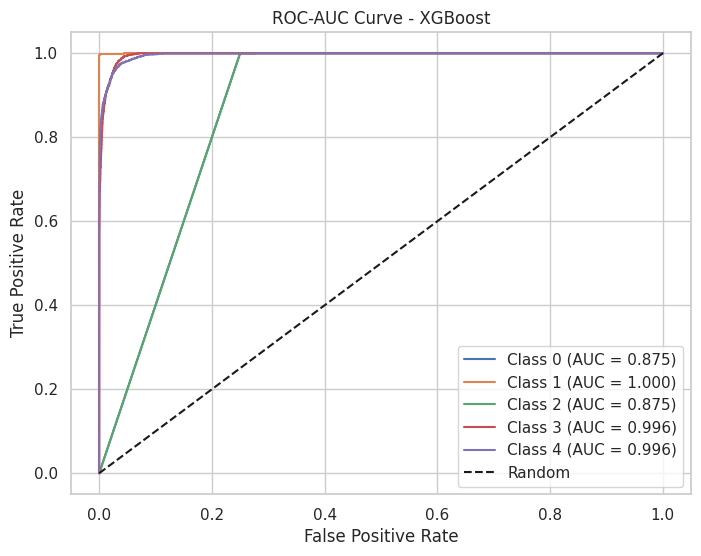

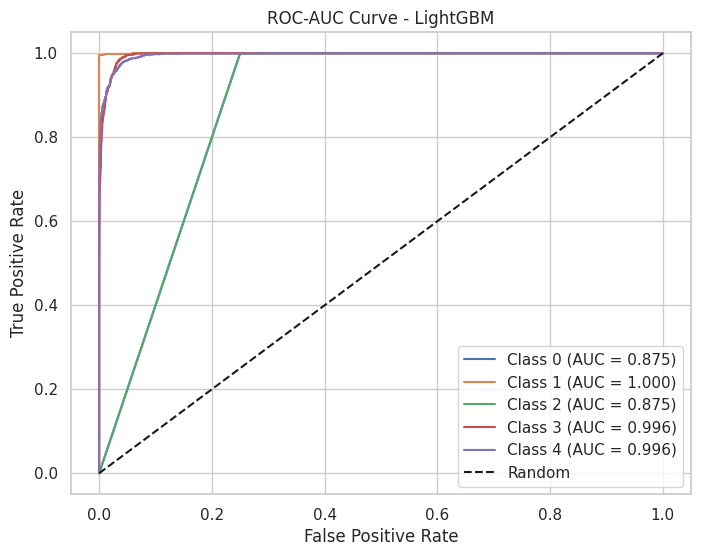

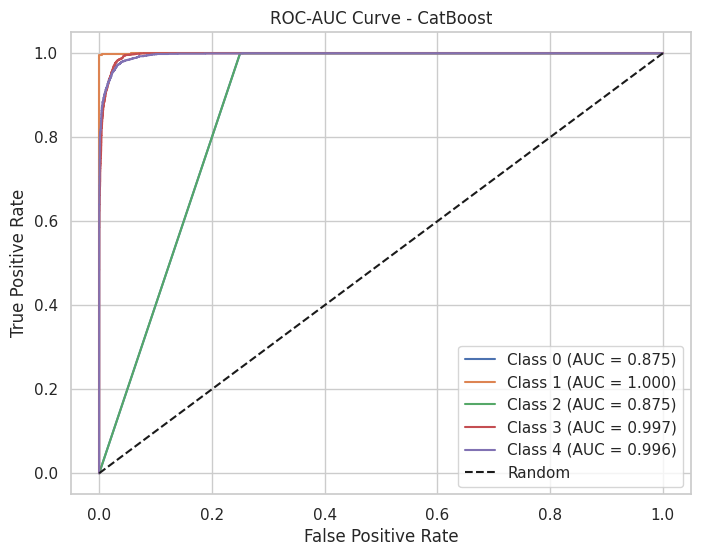

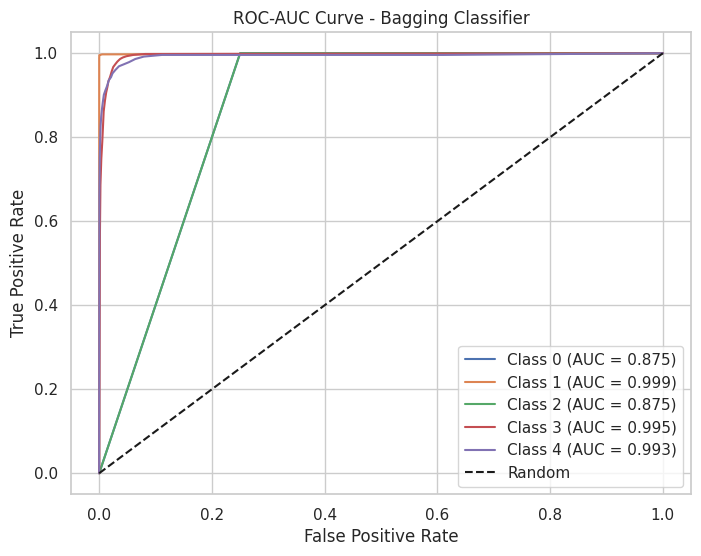

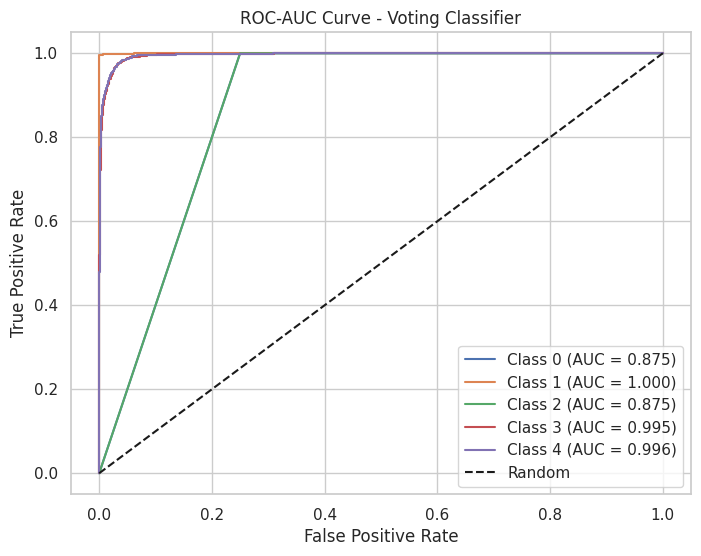

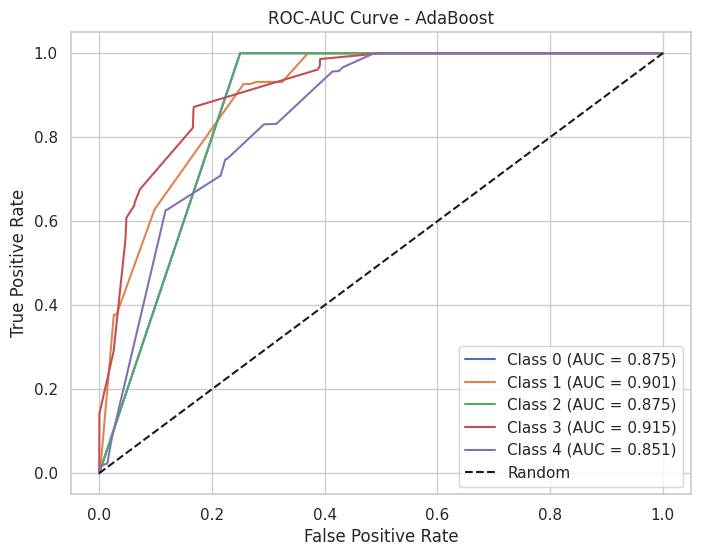

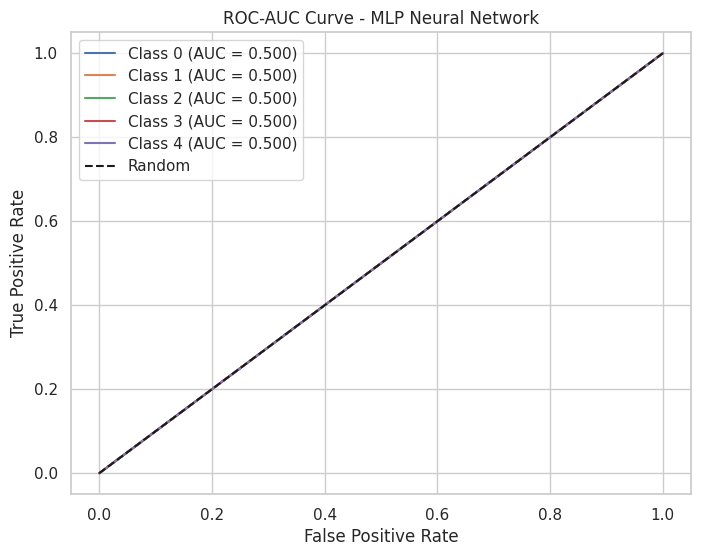

In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

print("\n===== MULTICLASS ROC-AUC CURVES =====")

classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)

def plot_roc_auc(model, name):
    # Check if model supports probability
    try:
        y_score = model.predict_proba(X_test)
    except:
        print(f"Skipping ROC curve for {name} (no predict_proba())")
        return

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Compute ROC curve for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all curves
    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        plt.plot(
            fpr[i], tpr[i],
            label=f"Class {classes[i]} (AUC = {roc_auc[i]:.3f})"
        )

    plt.plot([0,1], [0,1], "k--", label="Random")
    plt.title(f"ROC-AUC Curve - {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


for name, model in models.items():
    plot_roc_auc(model, name)



===== PRECISION–RECALL CURVES =====


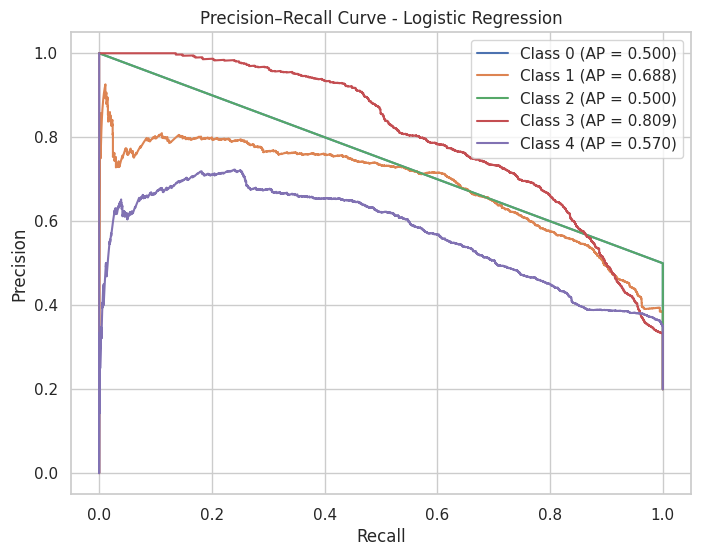

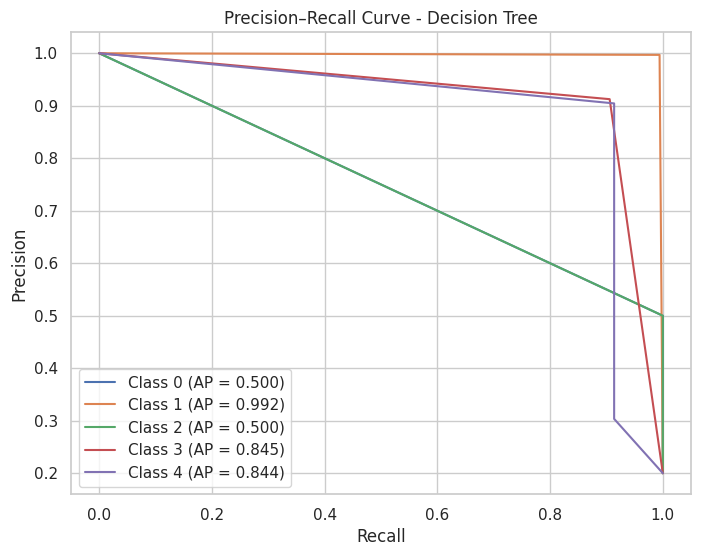

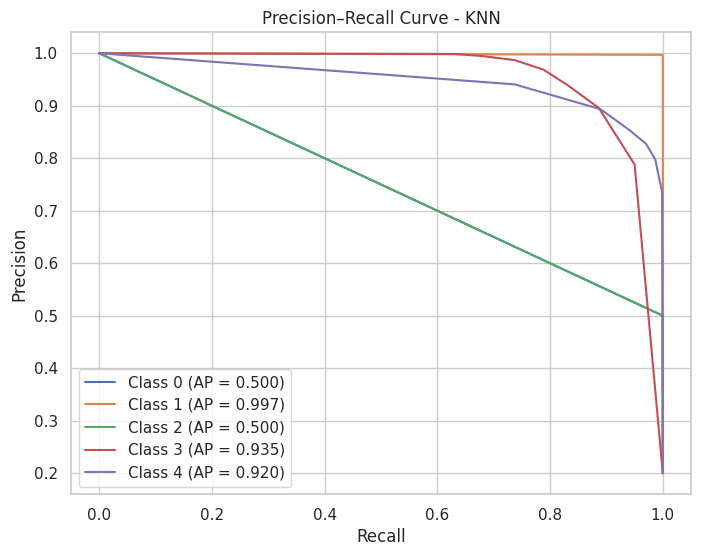

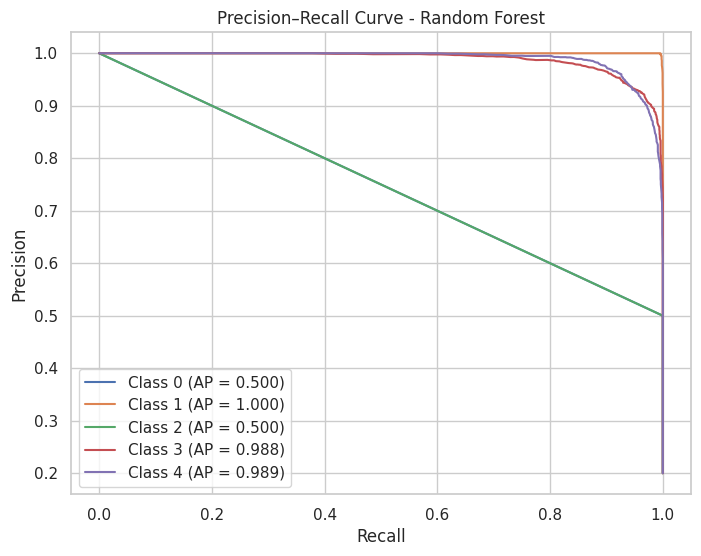

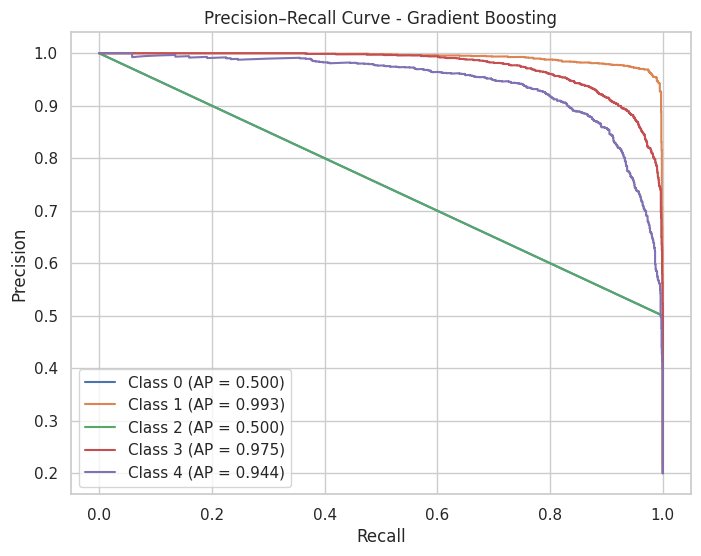

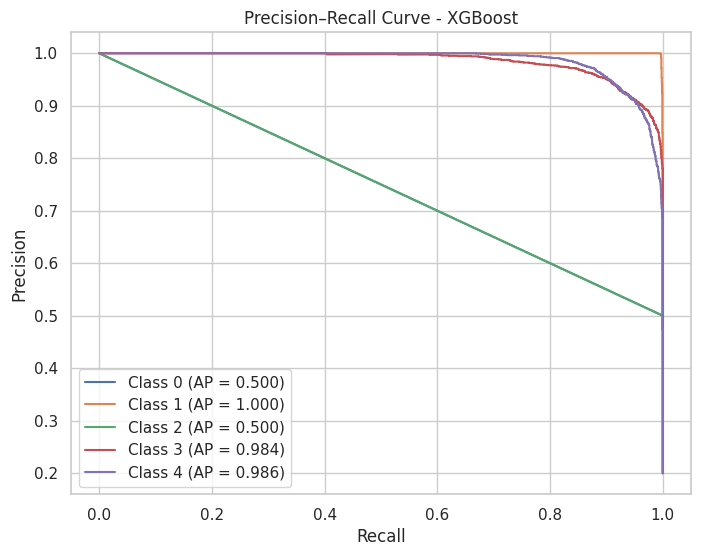

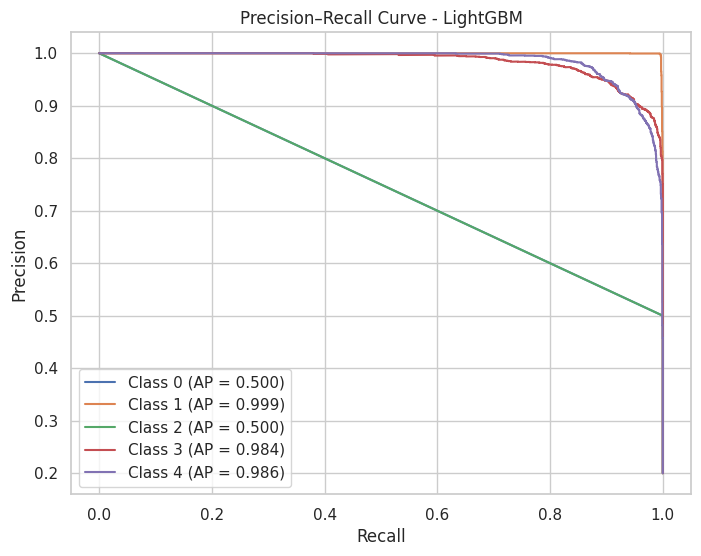

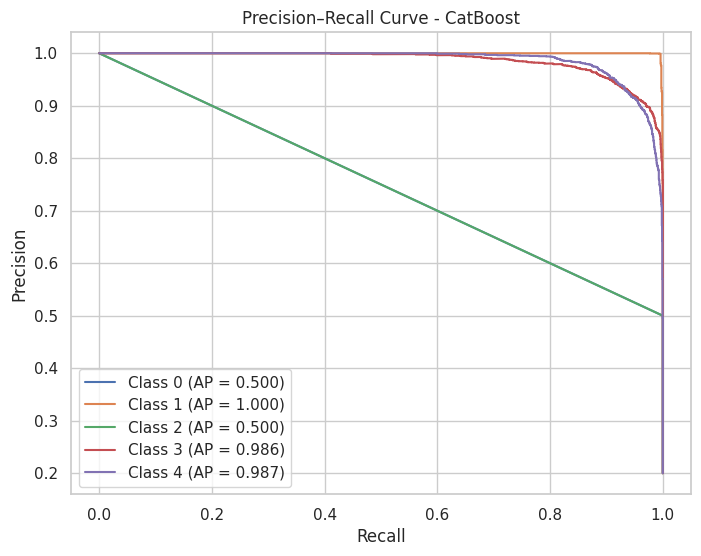

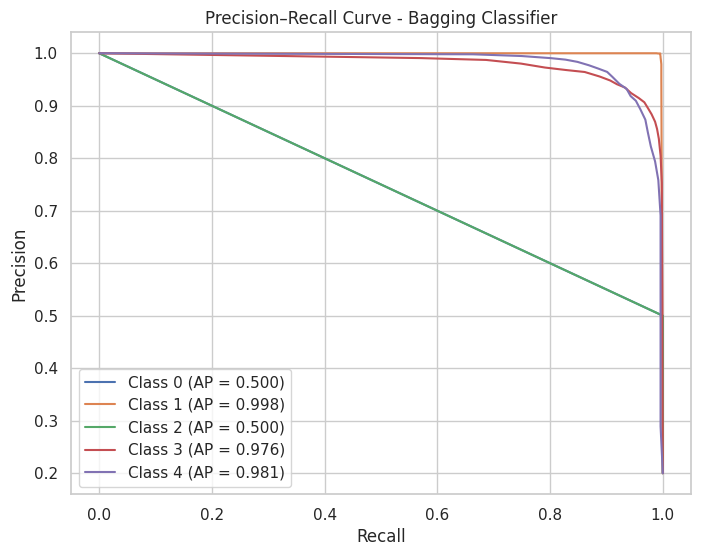

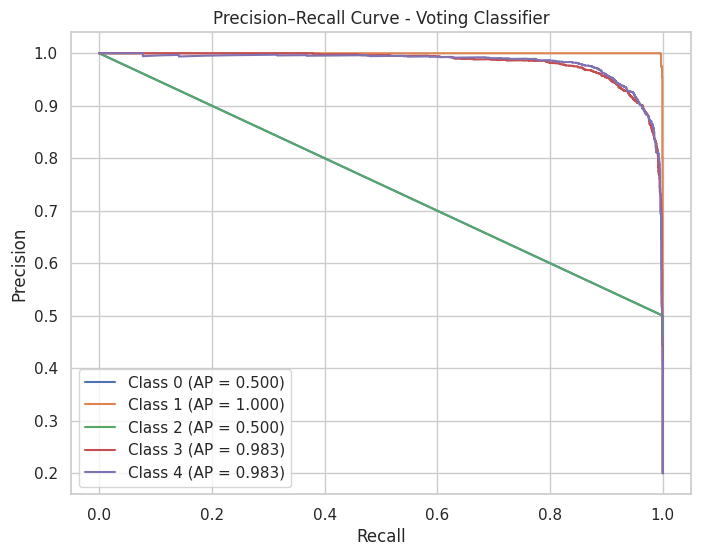

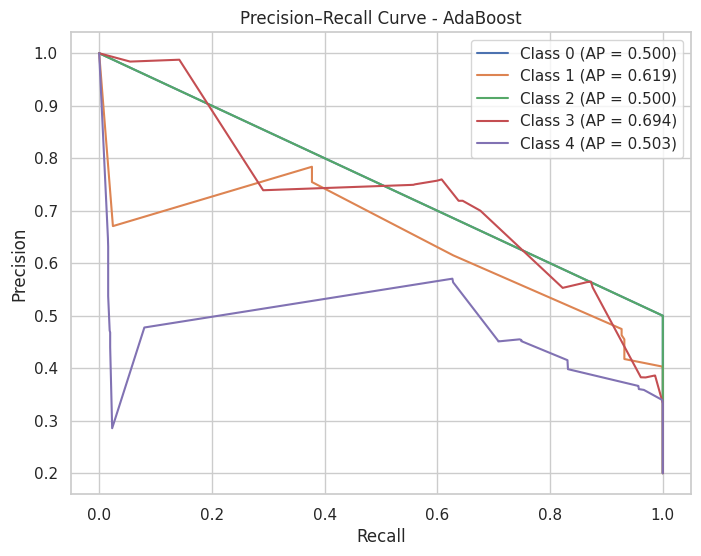

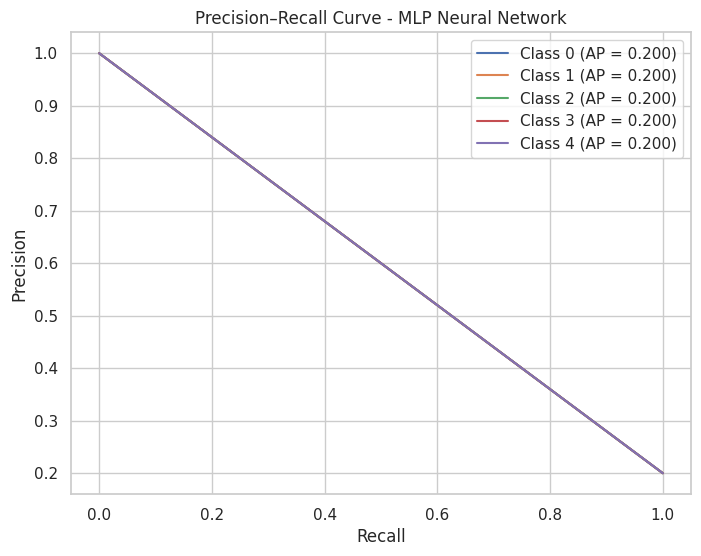


===== LEARNING CURVES =====


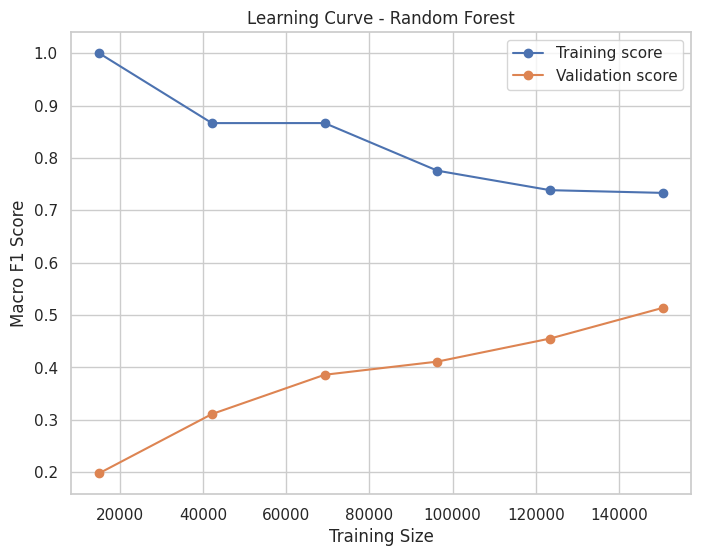

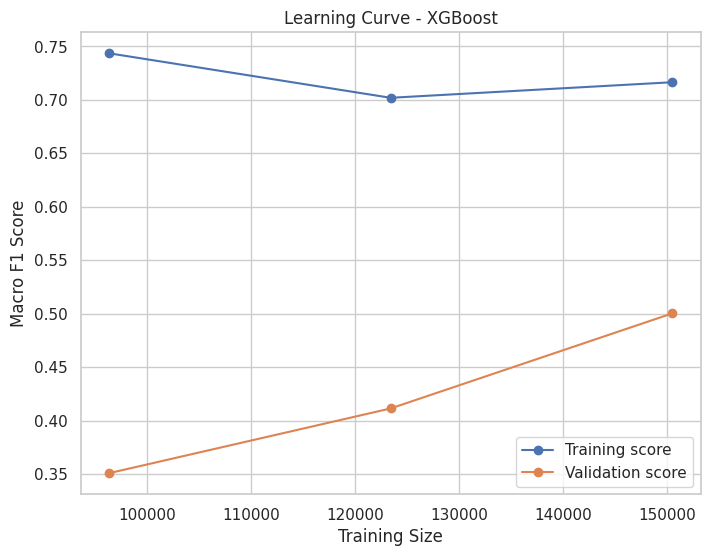

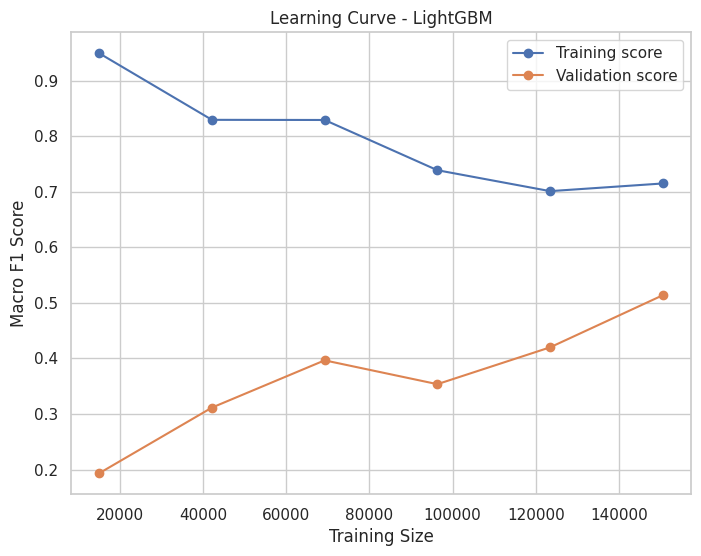

In [8]:

# =========================================================
# 6. MULTICLASS PRECISION–RECALL CURVES
# =========================================================

from sklearn.metrics import precision_recall_curve, average_precision_score

print("\n===== PRECISION–RECALL CURVES =====")

def plot_precision_recall(model, name):
    try:
        y_score = model.predict_proba(X_test)
    except:
        print(f"Skipping PR curve for {name} (no predict_proba())")
        return

    precision = dict()
    recall = dict()
    avg_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(
            y_test_bin[:, i], y_score[:, i]
        )
        avg_precision[i] = average_precision_score(
            y_test_bin[:, i], y_score[:, i]
        )

    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        plt.plot(
            recall[i], precision[i],
            label=f"Class {classes[i]} (AP = {avg_precision[i]:.3f})"
        )

    plt.title(f"Precision–Recall Curve - {name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

for name, model in models.items():
    plot_precision_recall(model, name)


# =========================================================
# 7. LEARNING CURVES (Random Forest, XGBoost, LightGBM)
# =========================================================

from sklearn.model_selection import learning_curve

print("\n===== LEARNING CURVES =====")

def plot_learning_curve(model, name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=3, scoring="f1_macro",
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 6)
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_mean, "o-", label="Training score")
    plt.plot(train_sizes, test_mean, "o-", label="Validation score")
    plt.title(f"Learning Curve - {name}")
    plt.xlabel("Training Size")
    plt.ylabel("Macro F1 Score")
    plt.legend()
    plt.show()


selected_models = {
    "Random Forest": models["Random Forest"],
    "XGBoost": models["XGBoost"],
    "LightGBM": models["LightGBM"]
}

for name, m in selected_models.items():
    plot_learning_curve(m, name)

In [10]:
import os
from sklearn.calibration import calibration_curve
from sklearn.metrics import precision_recall_curve, roc_curve, auc

OUT_DIR = "/content/model_curves"
os.makedirs(OUT_DIR, exist_ok=True)

print(f"\nSaving ALL curves to: {OUT_DIR}\n")

# Binarize labels for multiclass curves
classes = sorted(y_test.unique())
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = len(classes)


from sklearn.calibration import calibration_curve

def save_calibration(model, name):
    try:
        y_prob = model.predict_proba(X_test)[:, 0]  # Choose any class
    except:
        return

    prob_true, prob_pred = calibration_curve(
        (y_test == classes[0]).astype(int), y_prob, n_bins=10
    )

    plt.figure(figsize=(6,5))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1], 'k--')
    plt.title(f"Calibration Curve — {name}")
    plt.xlabel("Predicted probability")
    plt.ylabel("Actual probability")
    plt.savefig(f"{OUT_DIR}/Calibration_{name}.png", dpi=300, bbox_inches='tight')
    plt.close()

for name, model in models.items():
    save_calibration(model, name)


Saving ALL curves to: /content/model_curves



In [11]:
def save_gain_lift(model, name):
    try:
        prob = model.predict_proba(X_test).max(axis=1)
    except:
        return

    df_lift = pd.DataFrame({"prob": prob, "true": (y_test == y_test.mode()[0]).astype(int)})
    df_lift = df_lift.sort_values("prob", ascending=False)
    df_lift["cum_true"] = df_lift["true"].cumsum() / df_lift["true"].sum()
    df_lift["pct"] = np.arange(1, len(df_lift)+1) / len(df_lift)

    # Cumulative Gain Curve
    plt.figure(figsize=(7,5))
    plt.plot(df_lift["pct"], df_lift["cum_true"], label="Model")
    plt.plot([0,1],[0,1],'k--', label="Baseline")
    plt.title(f"Cumulative Gain Curve — {name}")
    plt.xlabel("Percentage of Samples")
    plt.ylabel("Cumulative Gain")
    plt.legend()
    plt.savefig(f"{OUT_DIR}/Gain_{name}.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Lift Curve
    plt.figure(figsize=(7,5))
    lift = df_lift["cum_true"] / df_lift["pct"]
    plt.plot(df_lift["pct"], lift)
    plt.title(f"Lift Curve — {name}")
    plt.xlabel("Percentage of Samples")
    plt.ylabel("Lift")
    plt.savefig(f"{OUT_DIR}/Lift_{name}.png", dpi=300, bbox_inches='tight')
    plt.close()

for name, model in models.items():
    save_gain_lift(model, name)


# =========================================================
# 5. KS Statistic Curve (NEW!)
# =========================================================

def save_ks_curve(model, name):
    try:
        prob = model.predict_proba(X_test)[:, 0]
    except:
        return

    # Sort by predicted prob
    df_ks = pd.DataFrame({"prob": prob, "true": (y_test == classes[0]).astype(int)})
    df_ks = df_ks.sort_values("prob", ascending=False)

    df_ks["cum_pos"] = (df_ks["true"]).cumsum() / df_ks["true"].sum()
    df_ks["cum_neg"] = ((1 - df_ks["true"]).cumsum()) / ((1 - df_ks["true"]).sum())

    plt.figure(figsize=(7,5))
    plt.plot(df_ks["cum_pos"].values, label="Positive CDF")
    plt.plot(df_ks["cum_neg"].values, label="Negative CDF")
    plt.title(f"KS Curve — {name}")
    plt.legend()
    plt.savefig(f"{OUT_DIR}/KS_{name}.png", dpi=300, bbox_inches='tight')
    plt.close()

for name, model in models.items():
    save_ks_curve(model, name)


# =========================================================
# 6. FEATURE IMPORTANCE CURVES (RF, XGB, LGB, CAT)
# =========================================================

important_models = ["Random Forest", "XGBoost", "LightGBM", "CatBoost"]

for name in important_models:
    model = models[name]

    try:
        importances = model.feature_importances_
    except:
        continue

    sorted_idx = np.argsort(importances)[::-1]
    feats = X.columns[sorted_idx]
    vals = importances[sorted_idx]

    plt.figure(figsize=(8,6))
    sns.barplot(x=vals[:15], y=feats[:15], palette="viridis")
    plt.title(f"Top 15 Feature Importances — {name}")
    plt.xlabel("Importance")
    plt.savefig(f"{OUT_DIR}/FI_{name}.png", dpi=300, bbox_inches='tight')
    plt.close()


print("\n🎉 All curves exported as PNG to:", OUT_DIR)


🎉 All curves exported as PNG to: /content/model_curves


Found 52 images.


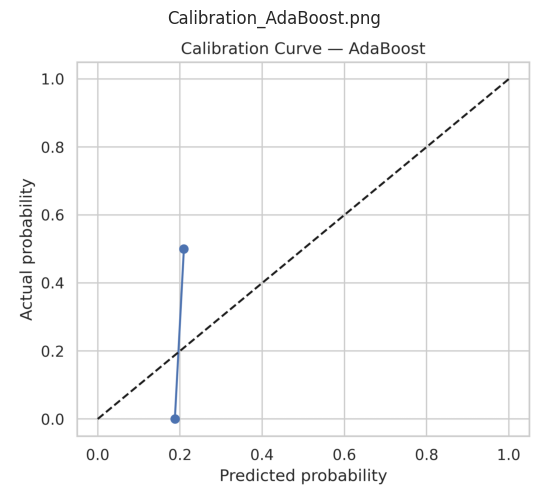

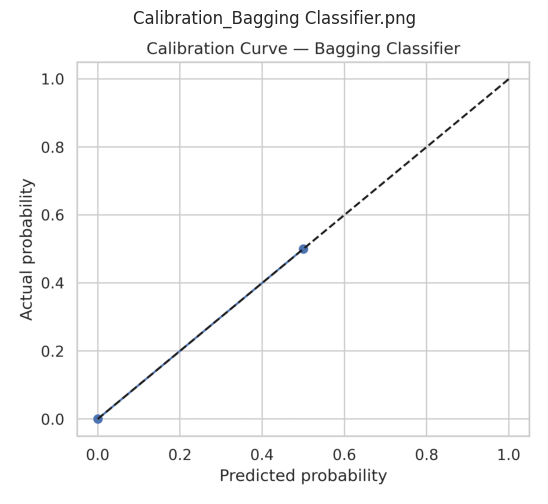

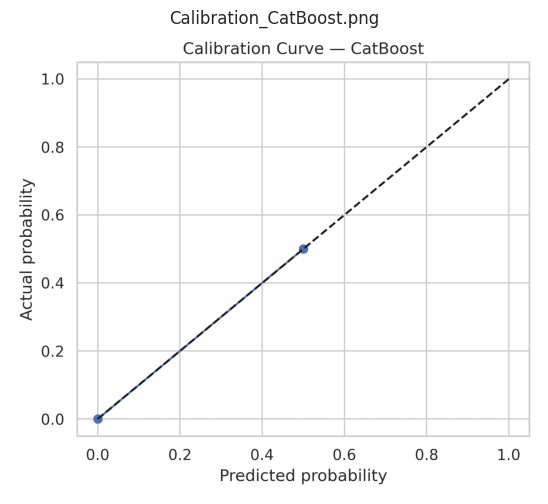

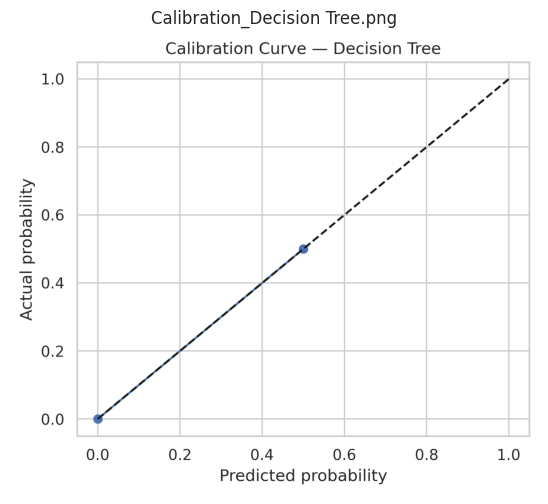

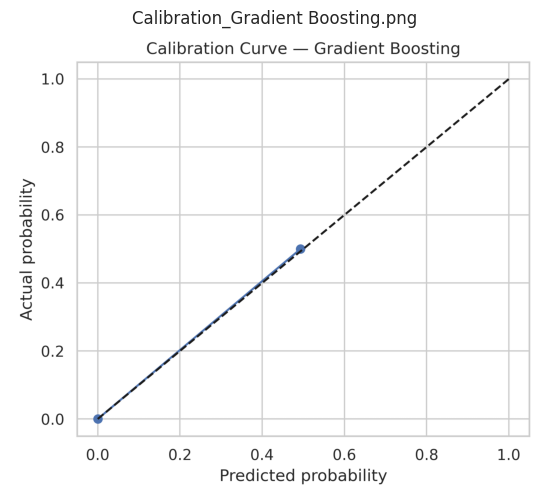

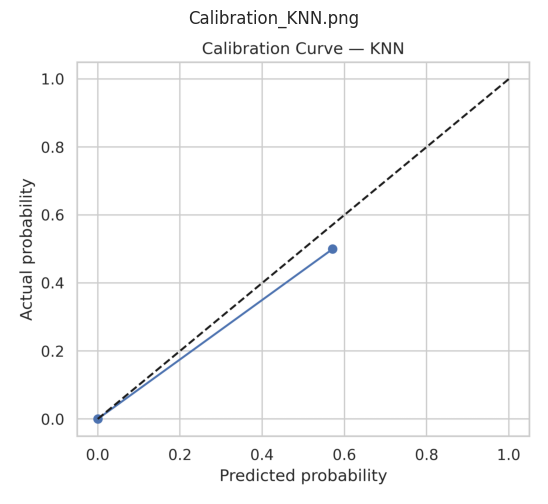

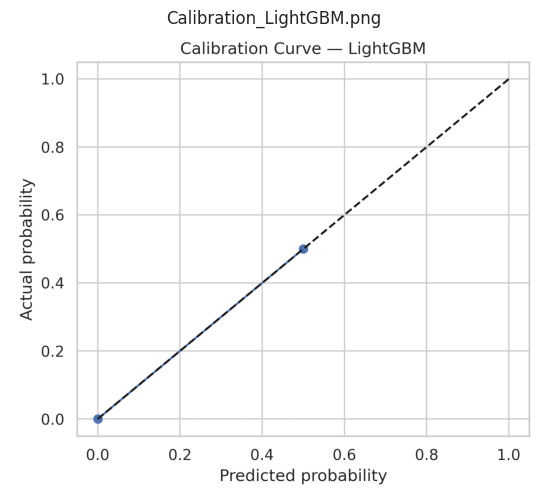

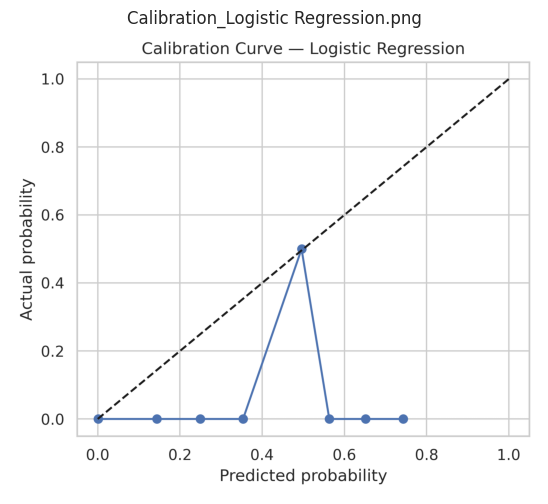

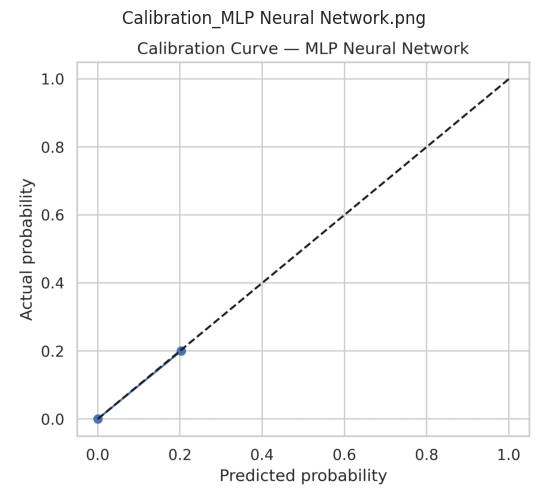

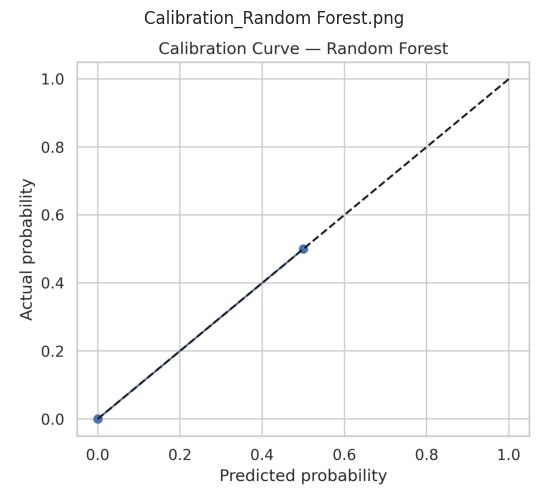

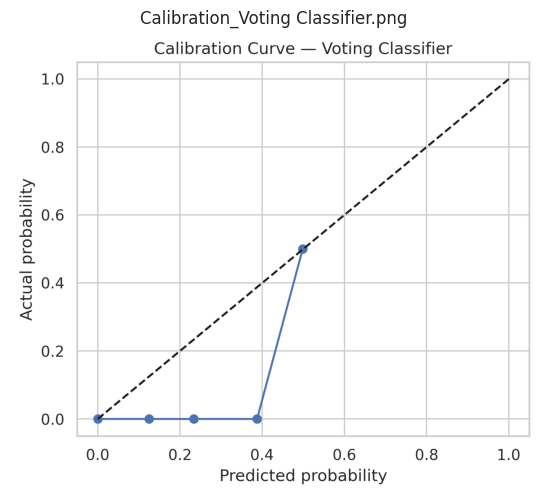

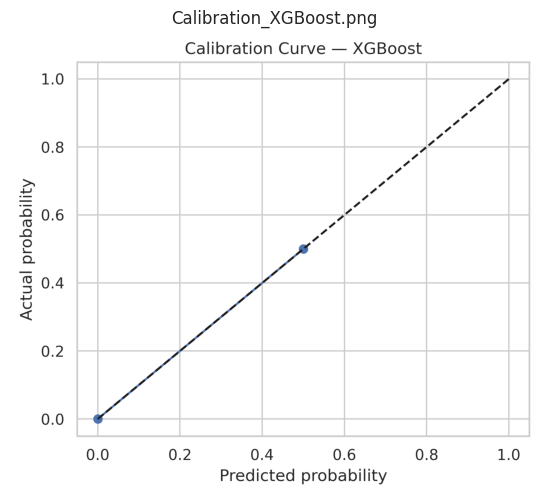

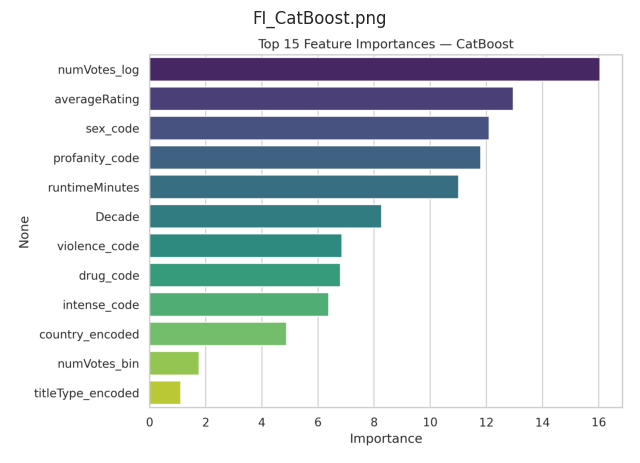

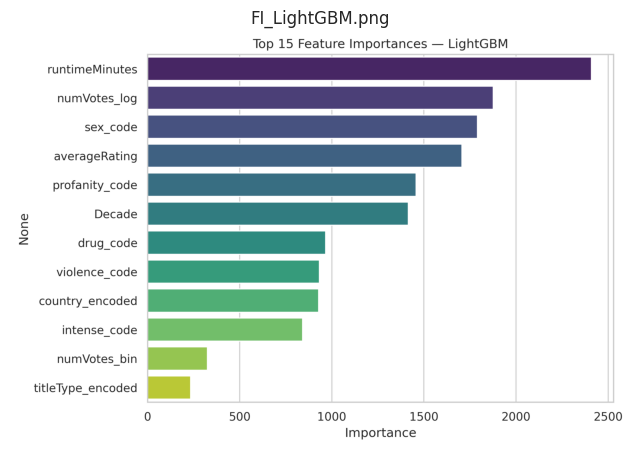

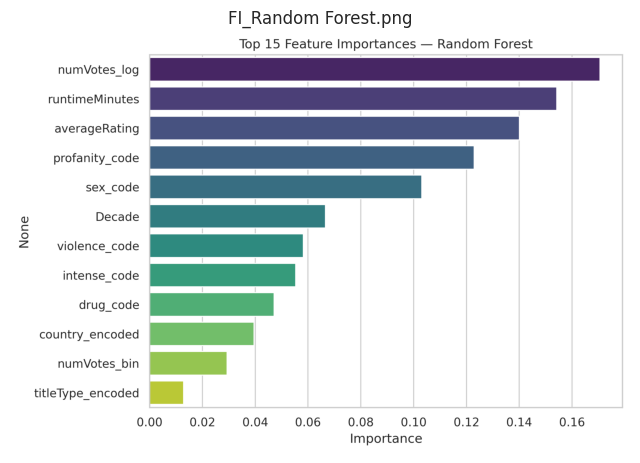

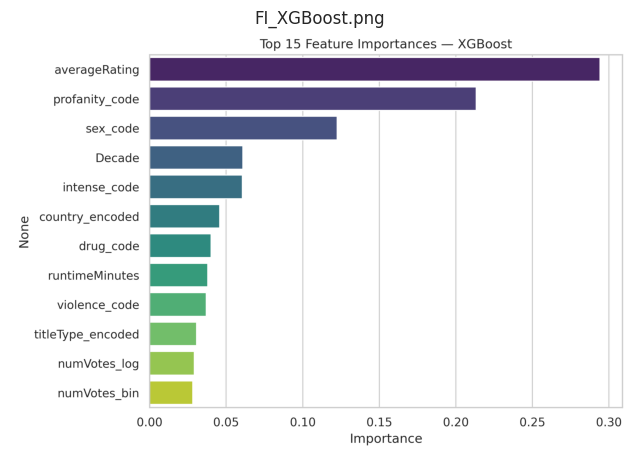

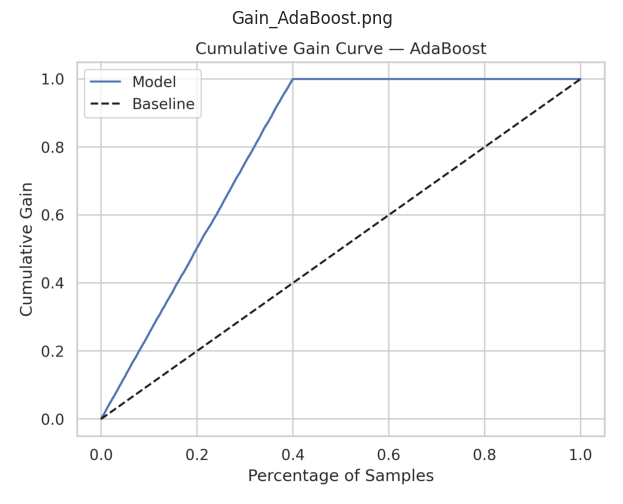

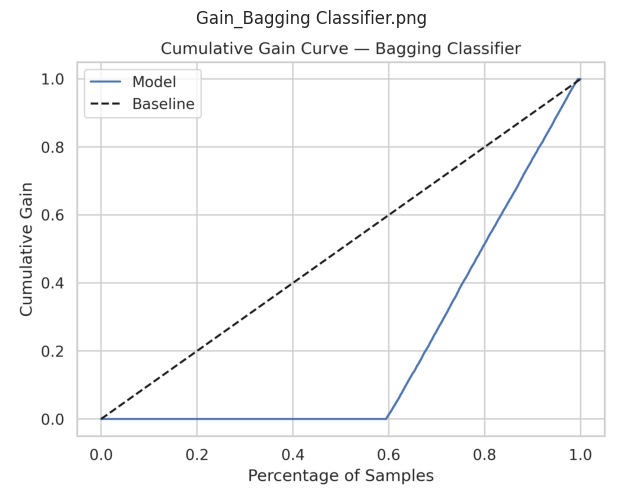

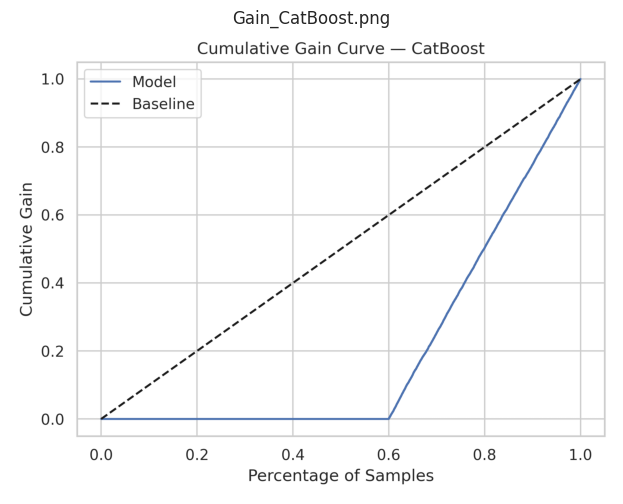

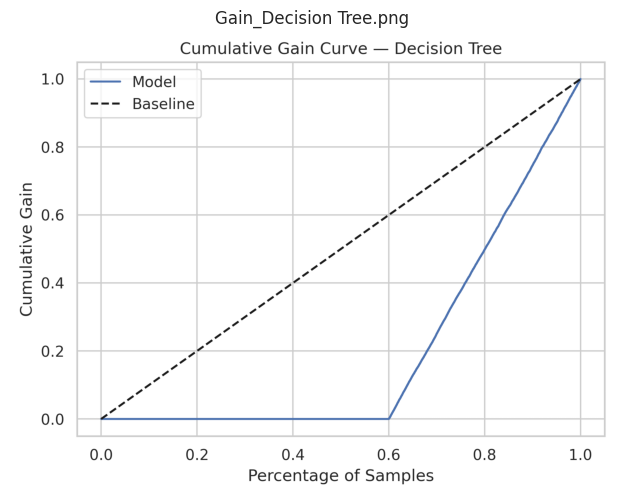

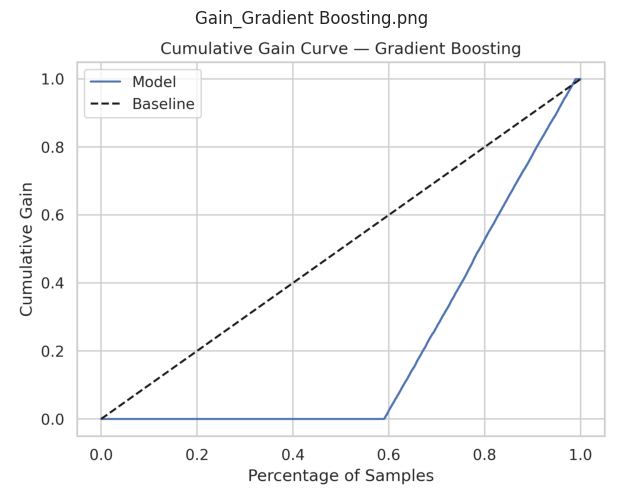

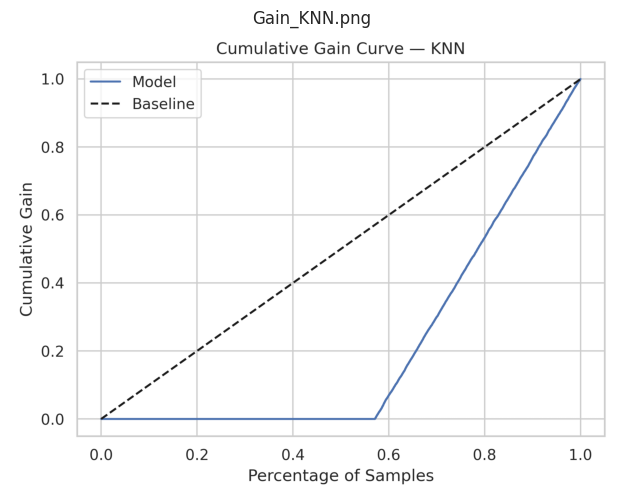

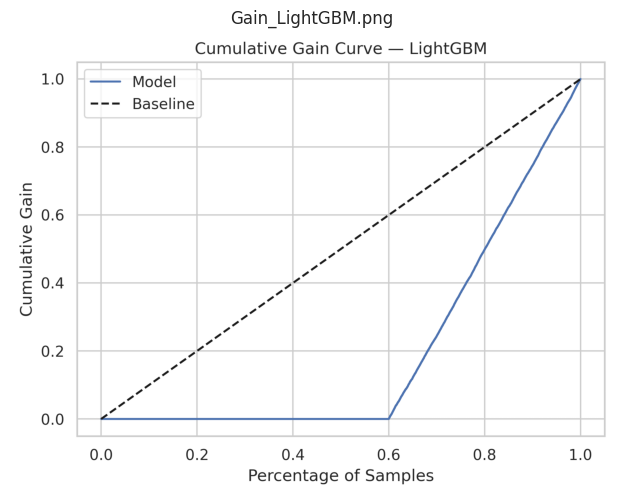

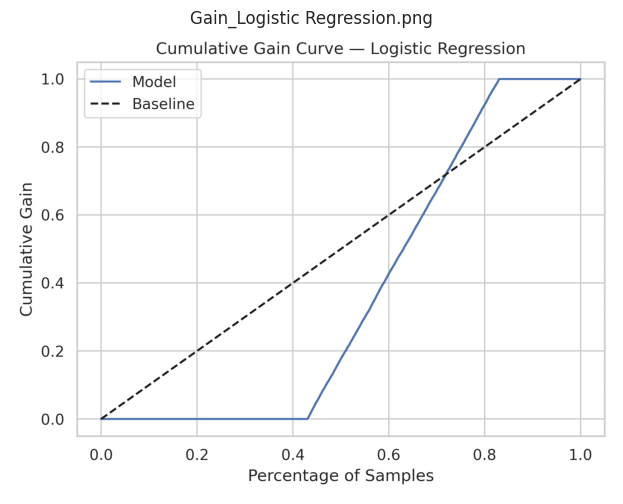

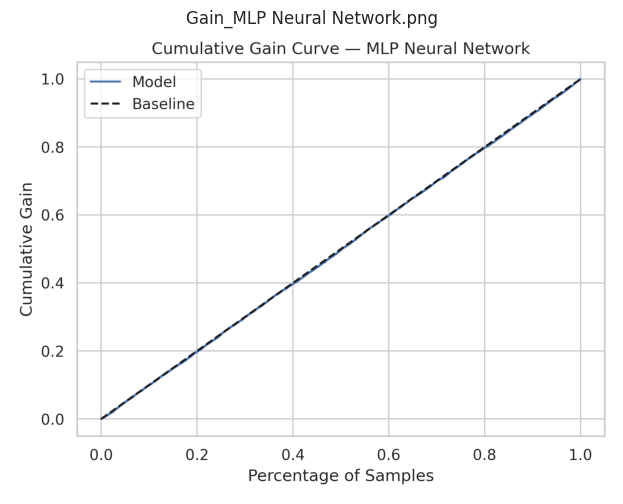

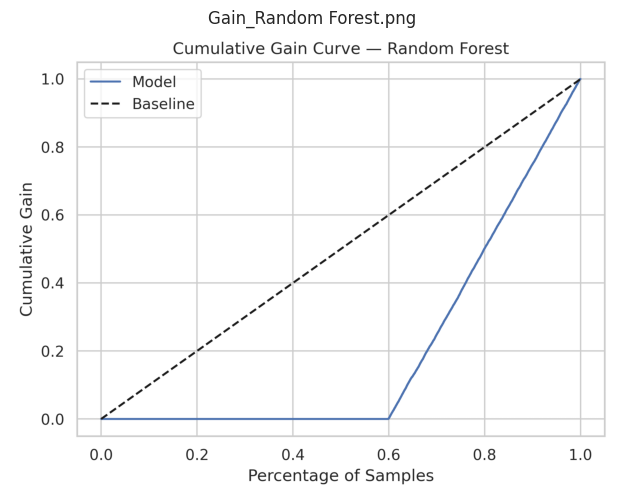

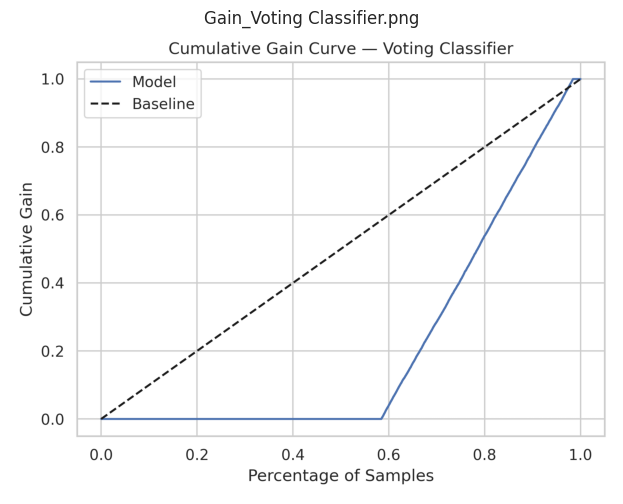

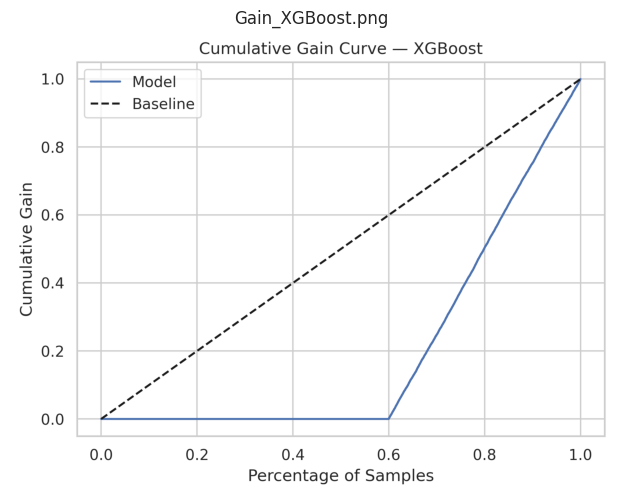

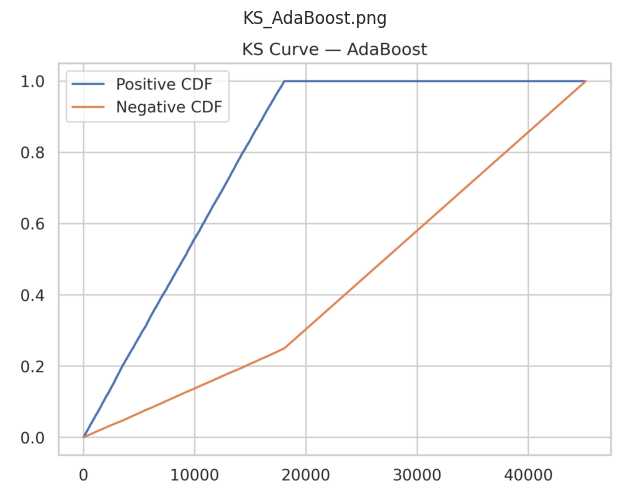

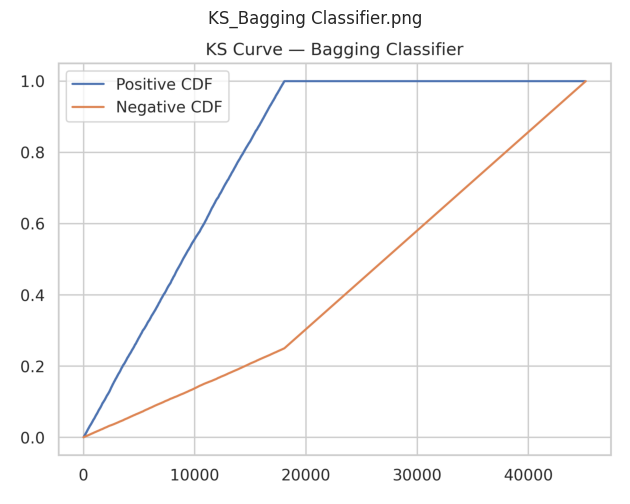

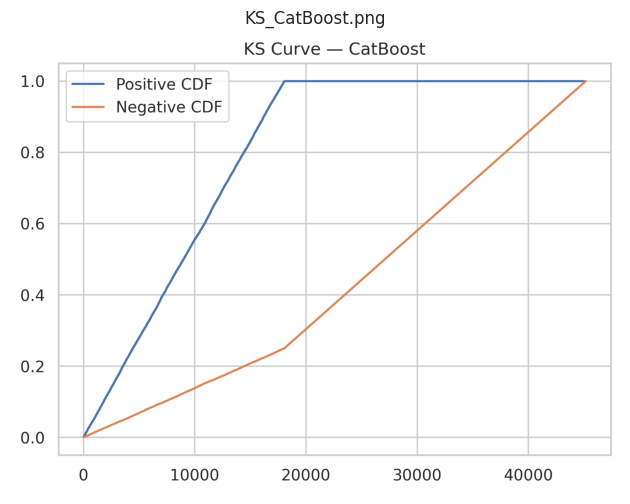

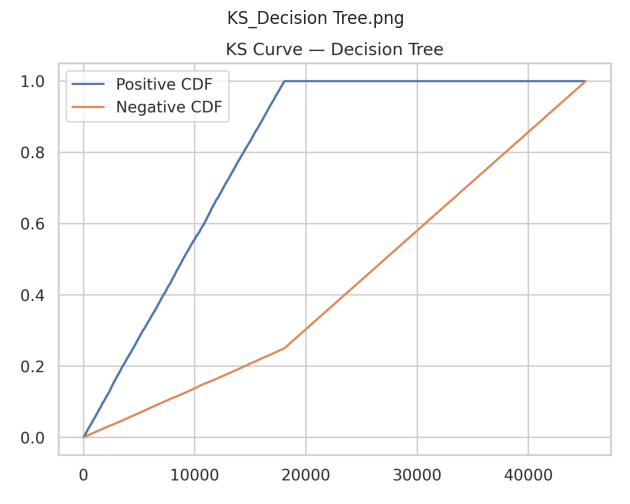

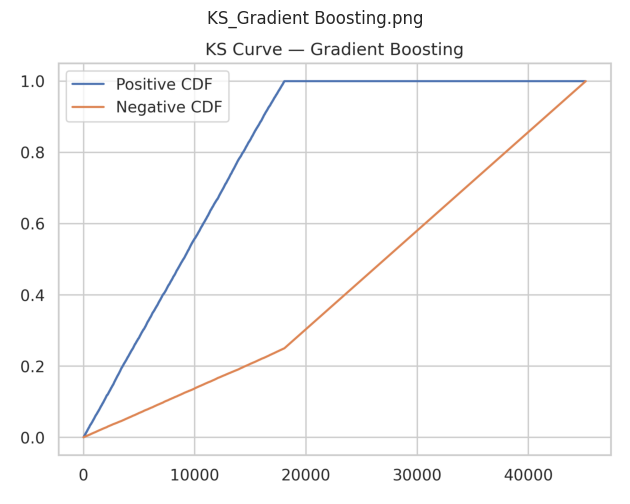

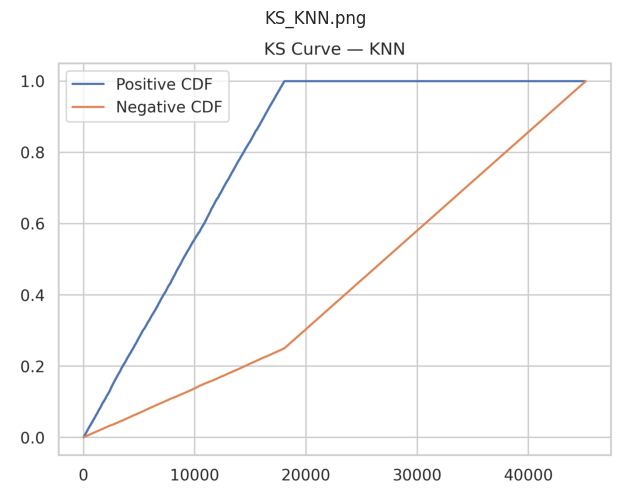

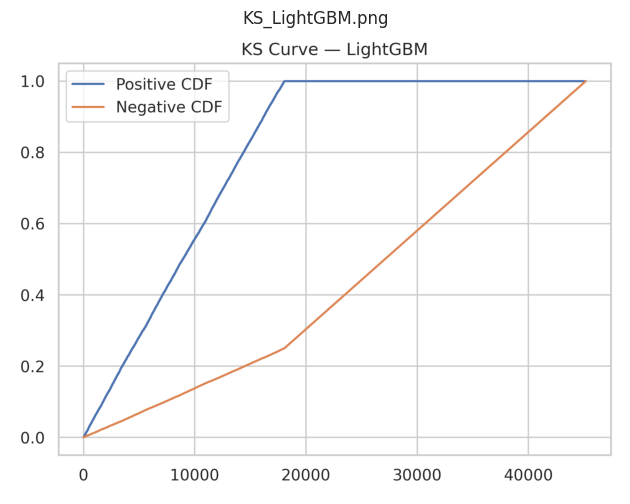

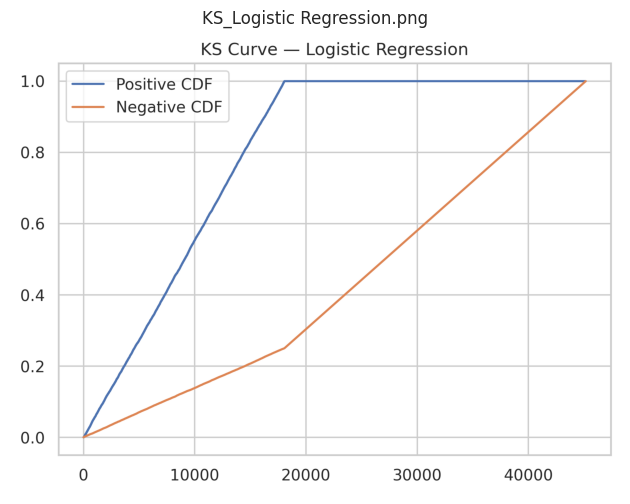

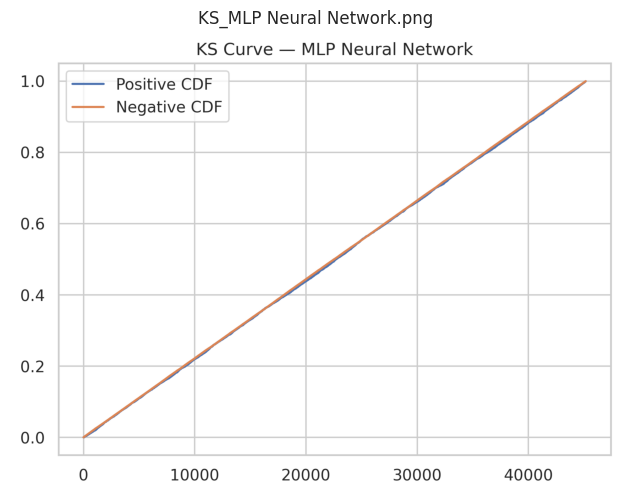

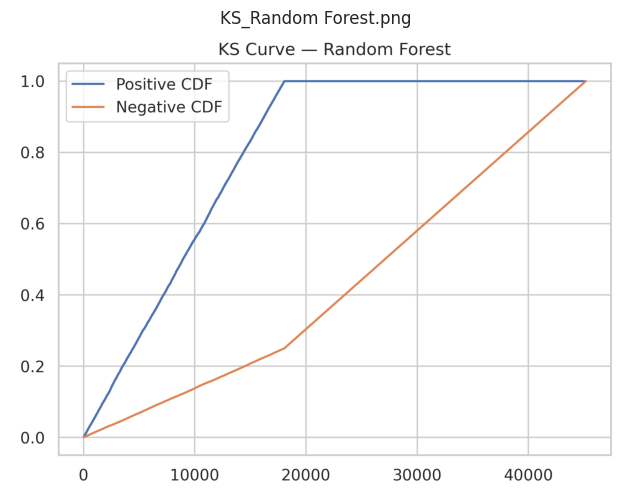

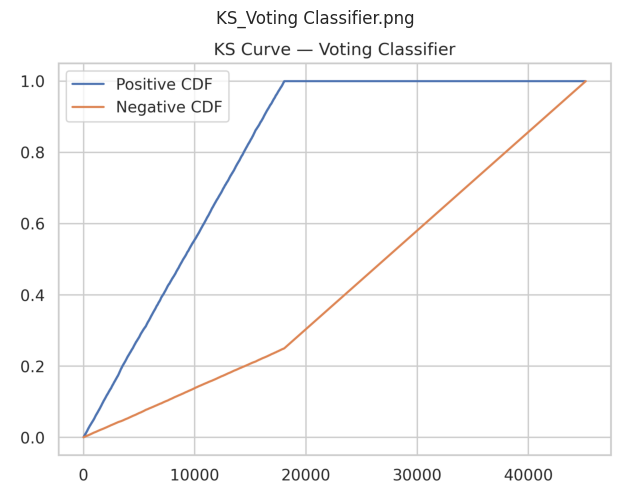

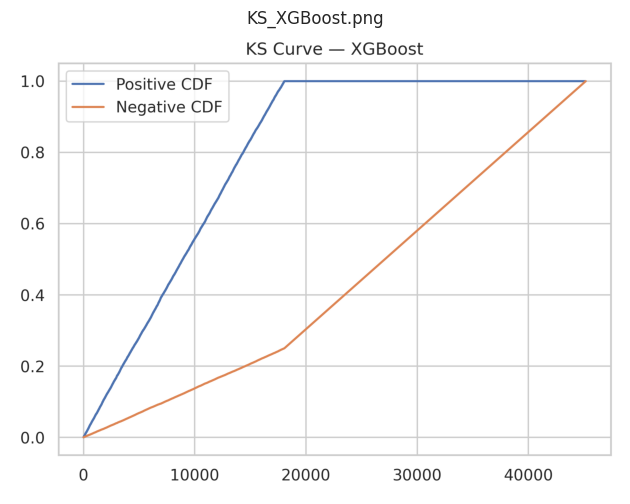

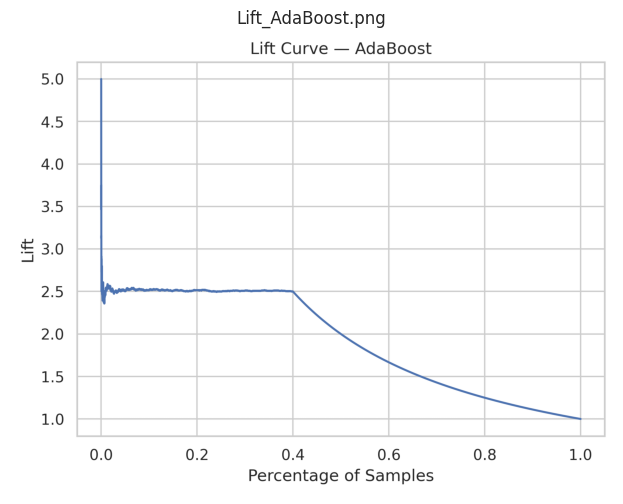

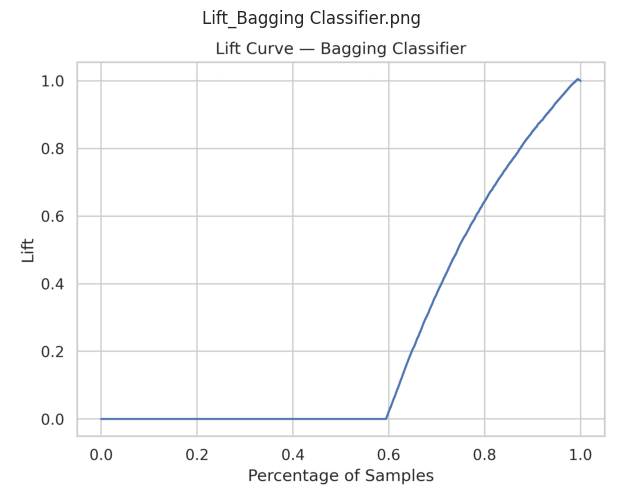

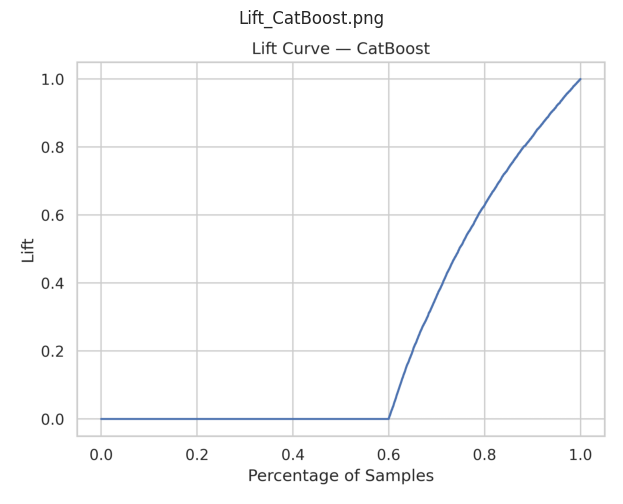

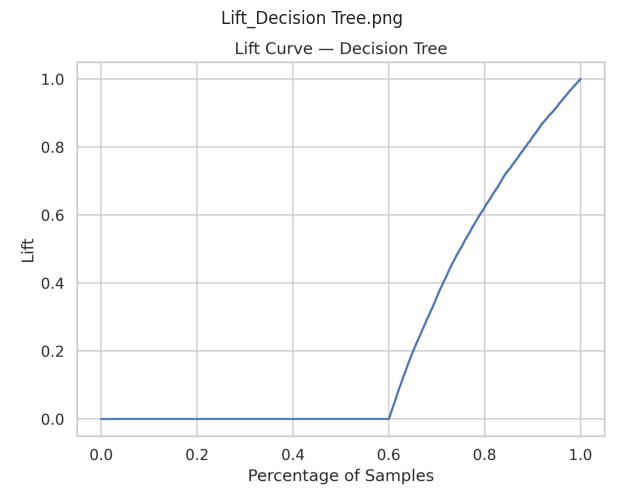

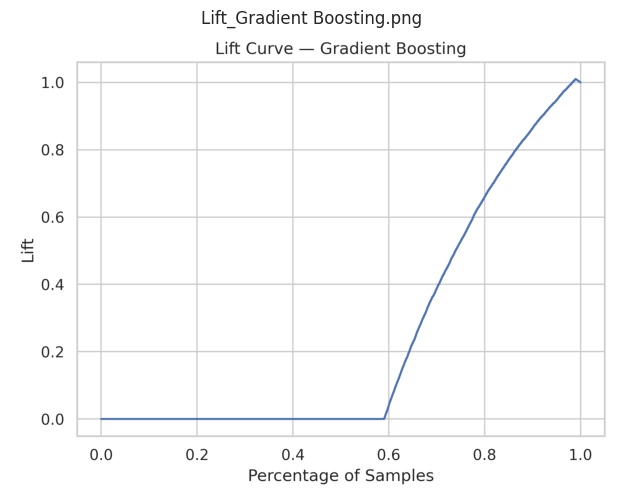

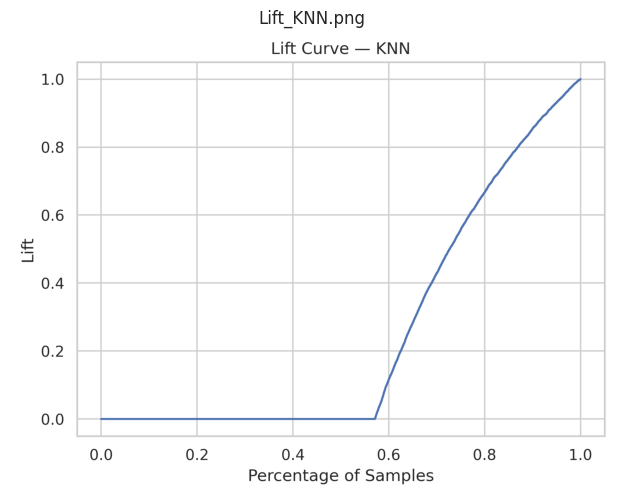

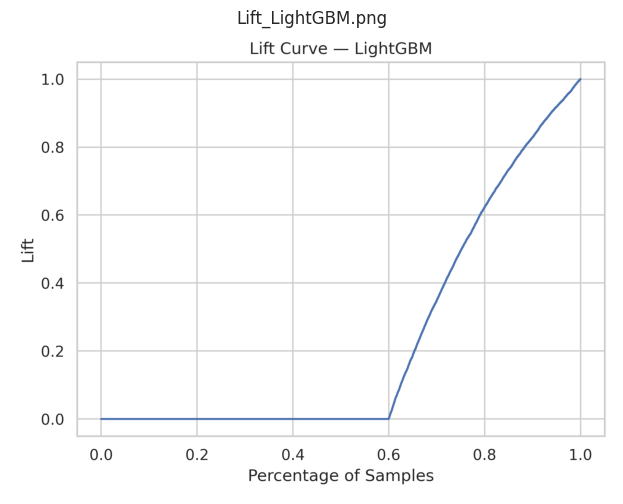

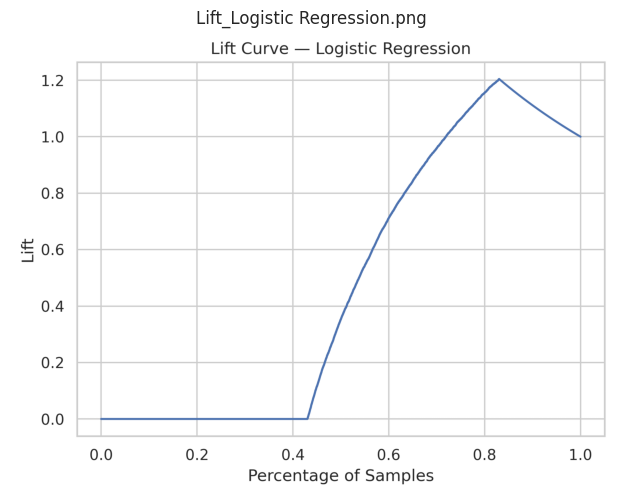

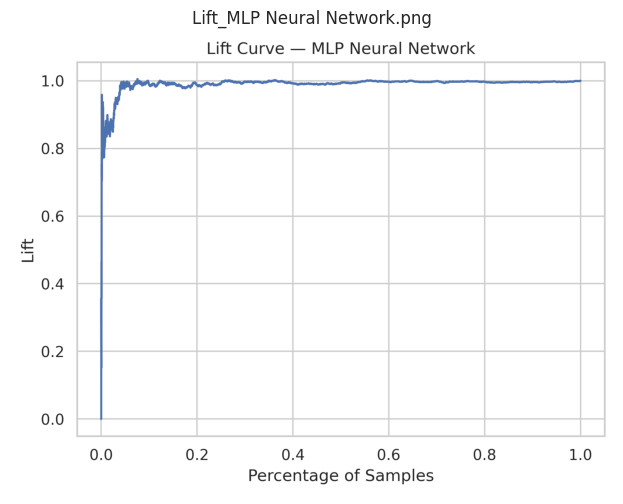

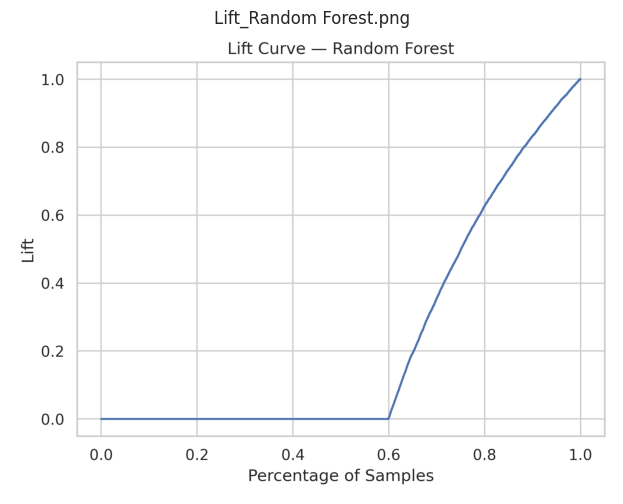

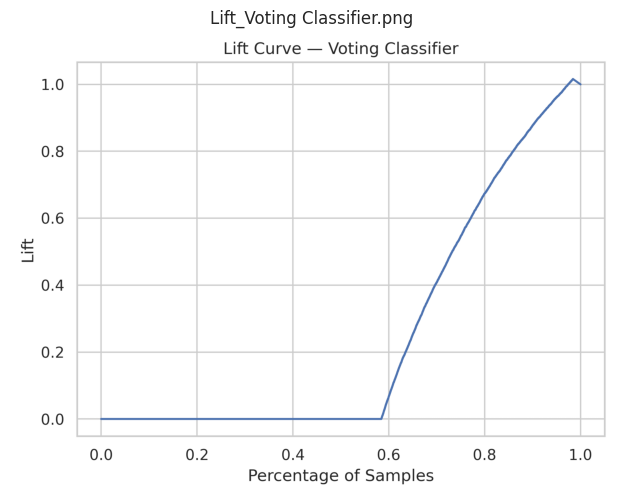

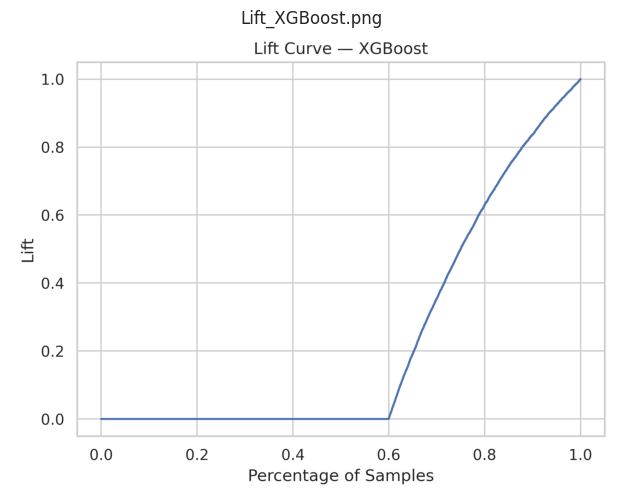

In [12]:
import os
from PIL import Image
import matplotlib.pyplot as plt

FOLDER = "/content/model_curves"

# List all PNG images in the folder
images = [f for f in os.listdir(FOLDER) if f.lower().endswith(".png")]

print(f"Found {len(images)} images.")

for img_name in sorted(images):
    img_path = os.path.join(FOLDER, img_name)

    # Load image
    img = Image.open(img_path)

    # Display
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)
    plt.show()
